# Classic Models Implementation
We are implementing different classic Machine Learning models for time series forecasting. We are using ElasticNet, K-Nearest Neighbour and Support Vector Regressor, to use them as a comparative baseline with the Neural Networks that will be built for the development of this TFM.

## Index
* [Classic Models Implementation](#Title)
* [Linear Regression](#second-bullet)

In [4]:
import os
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from tqdm.notebook import tqdm

from metrics import *

warnings.filterwarnings("ignore", module="tqdm")
warnings.filterwarnings("ignore", module="np")
plt.style.use("seaborn-v0_8-darkgrid")


PATH = "./data"
SYMBOLS = ["ADA", "BNB", "BTC", "EOS", "ETH", "LTC", "TRX", "VET", "XRP"]


def to_csvf(x):
    return x + "USDT.csv"

In [2]:
def read_file(symbol: str, tf: str, timestamp_unit: str = "ms") -> pd.DataFrame:
    """
    Reads a CSV file, assigns column names, converts the 'date' column to datetime,
    and sets it as the DataFrame's index.

    Parameters
    ----------
    symbol : str
        The symbol.
    tf : str
        The tf.
    timestamp_unit : str, default 'ms'
        The unit of the timestamp in the 'date' column. By default, it's 'ms' (milliseconds).

    Returns
    -------
    pd.DataFrame
        The DataFrame with the 'date' column converted to datetime and set as the index.
    """

    df = pd.read_csv(to_csvf(os.path.join(PATH, tf, symbol)), header=None).iloc[:, 0:6]
    df.columns = ["date", "open", "high", "low", "close", "volume"]
    df["date"] = pd.to_datetime(df["date"], unit=timestamp_unit)
    df.set_index("date", inplace=True)

    return df

In [3]:
def read_and_crop_data(symbol, tf_target, min_date, max_date):
    df = read_file(symbol, tf_target)
    if df is not None:
        if symbol == "BTC":
            full_index = pd.date_range(df.index.min(), df.index.max(), freq="8H")
            df_full = pd.DataFrame(index=full_index)
            # Create the new dataframe forwarding missing values
            df = (
                df_full.merge(df, left_index=True, right_index=True, how="left")
                .fillna(method="ffill")
                .loc[min_date:max_date]
            )
        else:
            df = df.loc[min_date:max_date]
    return df


def get_common_date_range(symbols, tf_target):
    print("[INFO] -- Determining common date range.")
    min_date = pd.Timestamp("1900-01-01")
    max_date = pd.Timestamp("2100-01-01")

    for symbol in symbols:
        if symbol != "BTC":
            df = read_file(symbol, tf_target)
            if df is not None:
                min_date = max(min_date, df.index.min())
                max_date = min(max_date, df.index.max())

    print(f"[INFO] -- Common date range determined: {min_date} to {max_date}")
    return min_date, max_date


def k_fold_ts_split(df, k, n):
    """
    Custom k-fold train-test split function for time series data.

    Parameters:
    - df: DataFrame containing the data
    - k: Number of folds
    - n: Index of the fold to be used as test data

    Returns:
    - train_data: DataFrame containing training data
    - test_data: DataFrame containing test data
    """
    if n >= k:
        raise ValueError("Test fold index n should be less than the number of folds k.")

    if df is not None:
        if len(df) % k != 0:
            raise ValueError(
                f"The length of DataFrame is not divisible by {k} without a remainder."
            )

        fold_size = df.index.size // k
        test_start = n * fold_size
        test_end = (n + 1) * fold_size

        test_data = df.iloc[test_start:test_end]
        train_data = pd.concat([df.iloc[:test_start], df.iloc[test_end:]])

        return train_data, test_data
    else:
        raise ValueError("DataFrame is empty.")

In [4]:
# Assuming read_and_crop_data, get_common_date_range, and k_fold_ts_split are defined elsewhere


def prepare_data(
    symbols, tf_target="1d", use_k_fold=False, k=None, n=None, lag_days=250
):
    print("[INFO] -- Starting data preparation.")

    # Initialize dictionaries
    train_data_dict = {}
    test_data_dict = {}
    scaler_dict = {}

    # Get common date range
    min_date, max_date = get_common_date_range(symbols, tf_target)

    # Step 1: Read and crop data
    data_dict = {}
    # ipdb.set_trace(context=10)
    for symbol in tqdm(symbols, desc="Reading data"):  # tqdm progress bar
        print(f"[INFO] -- Reading data for {symbol}.")
        if symbol == "BTC":
            df = read_and_crop_data(
                symbol, tf_target, min_date - pd.Timedelta(days=lag_days), max_date
            )
        else:
            df = read_and_crop_data(symbol, tf_target, min_date, max_date)
            # Select only the 'close' column but keep it as a DataFrame
            df = df[["close"]]
        data_dict[symbol] = df

    # Step 2: Scale the data
    # tqdm progress bar

    # ipdb.set_trace(context=10)
    for symbol, df in tqdm(data_dict.items(), desc="Scaling data"):
        if df is not None:
            if symbol == "BTC":
                for column in df.columns:
                    scaler = MinMaxScaler()
                    df[column] = scaler.fit_transform(df[[column]])
                    scaler_dict[f"{symbol}_{column}"] = scaler
                btc = df.copy()
            else:
                scaler = MinMaxScaler()
                df["close"] = scaler.fit_transform(df[["close"]])
                scaler_dict[symbol] = scaler

    # Step 4: Calculate the train-test split dates

    # ipdb.set_trace(context=10)
    if use_k_fold:
        fold_size = len(data_dict["ADA"]) // k
        test_start_date = data_dict["ADA"].index[n * fold_size]
        test_end_date = data_dict["ADA"].index[(n + 1) * fold_size - 1]
        print(
            f"Fold Size: {fold_size} Test Start: {test_start_date} Tests End: {test_end_date}"
        )
    else:
        test_start_idx = int(len(data_dict["ADA"]) * 0.5)
        test_start_date = data_dict["ADA"].index[test_start_idx]
        test_end_date = data_dict["ADA"].index[-1]

    # Apply the train-test split dates to all dataframes
    # tqdm progress bar
    for symbol, df in tqdm(data_dict.items(), desc="Train-test splitting"):
        if df is not None:
            if use_k_fold:
                # ipdb.set_trace(context=10)
                if symbol == "BTC":
                    test_data = btc.loc[
                        test_start_date - pd.Timedelta(days=lag_days) : test_end_date
                    ].iloc[:-1]
                    train_data = pd.concat(
                        [
                            btc.loc[:test_start_date].iloc[:-1],
                            btc.loc[test_end_date - pd.Timedelta(days=lag_days) :],
                        ]
                    )
                else:
                    test_data = df.loc[test_start_date:test_end_date].iloc[:-1]
                    train_data = pd.concat(
                        [df.loc[:test_start_date].iloc[:-1], df.loc[test_end_date:]]
                    )
            else:
                if symbol == "BTC":
                    train_data = btc.loc[:test_start_date]
                    test_data = btc.loc[
                        test_start_date - pd.Timedelta(days=lag_days) : test_end_date
                    ]
                else:
                    train_data = df.loc[:test_start_date]
                    test_data = df.loc[test_start_date:test_end_date]

            train_data_dict[symbol] = train_data.loc[
                ~train_data.index.duplicated(keep="first")
            ]
            test_data_dict[symbol] = test_data.loc[
                ~test_data.index.duplicated(keep="first")
            ]
    # Step 5: Prepare BTC features based on ADA's index
    for set_type, data_dict in tqdm(
        [("train", train_data_dict), ("test", test_data_dict)],
        desc="Preparing BTC features",
    ):
        ada_index = data_dict["ADA"].index
        features = []
        for day in range(1, lag_days + 1):
            for timeframe in range(3):
                for variable in ["open", "high", "low", "close", "volume"]:
                    features.append(f"{variable}_day{day}_timeframe{timeframe}")

        btc_features = pd.DataFrame(index=ada_index, columns=features)
        btc_data = data_dict["BTC"]

        btc_data = btc_data[~btc_data.index.duplicated(keep="first")]
        # Get last 250 days to use them for the test set
        # tqdm progress bar
        for current_date in tqdm(
            ada_index, desc=f"Preparing BTC features for {set_type} set"
        ):
            row = []
            for day in range(1, lag_days + 1):
                past_date = current_date - pd.Timedelta(days=day)
                daily_data = btc_data[
                    (btc_data.index.year == past_date.year)
                    & (btc_data.index.month == past_date.month)
                    & (btc_data.index.day == past_date.day)
                ]
                row.extend(daily_data.values.flatten())
            btc_features.loc[current_date] = row

        data_dict["BTC"] = btc_features

    print("[INFO] -- Data preparation completed successfully.")

    return train_data_dict, test_data_dict, scaler_dict

In [5]:
%time
# Example usage
# SYMBOLS = ['ADA', 'BTC', ...]
train_data_dict, test_data_dict, scalers = prepare_data(
    SYMBOLS, use_k_fold=False, k=10, n=0
)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs
[INFO] -- Starting data preparation.
[INFO] -- Determining common date range.
[INFO] -- Common date range determined: 2018-07-25 00:00:00 to 2023-08-07 00:00:00


Reading data:   0%|          | 0/9 [00:00<?, ?it/s]

[INFO] -- Reading data for ADA.
[INFO] -- Reading data for BNB.
[INFO] -- Reading data for BTC.
[INFO] -- Reading data for EOS.
[INFO] -- Reading data for ETH.
[INFO] -- Reading data for LTC.
[INFO] -- Reading data for TRX.
[INFO] -- Reading data for VET.
[INFO] -- Reading data for XRP.


Scaling data:   0%|          | 0/9 [00:00<?, ?it/s]

Train-test splitting:   0%|          | 0/9 [00:00<?, ?it/s]

Preparing BTC features:   0%|          | 0/2 [00:00<?, ?it/s]

Preparing BTC features for train set:   0%|          | 0/921 [00:00<?, ?it/s]

Preparing BTC features for test set:   0%|          | 0/920 [00:00<?, ?it/s]

[INFO] -- Data preparation completed successfully.


In [6]:
# Assuming read_and_crop_data, get_common_date_range, and k_fold_ts_split are defined elsewhere


def prepare_data(
    symbols, tf_target="1d", use_k_fold=False, k=None, n=None, lag_days=250
):
    print("[INFO] -- Starting data preparation.")

    # Initialize dictionaries
    train_data_dict = {}
    test_data_dict = {}
    scaler_dict = {}

    # Get common date range
    min_date, max_date = get_common_date_range(symbols, tf_target)

    # Step 1: Read and crop data
    data_dict = {}
    # ipdb.set_trace(context=10)
    for symbol in tqdm(symbols, desc="Reading data"):  # tqdm progress bar
        print(f"[INFO] -- Reading data for {symbol}.")
        if symbol == "BTC":
            df = read_and_crop_data(
                symbol, tf_target, min_date - pd.Timedelta(days=lag_days), max_date
            )
        else:
            df = read_and_crop_data(symbol, tf_target, min_date, max_date)
            # Select only the 'close' column but keep it as a DataFrame
            df = df[["close"]]
        data_dict[symbol] = df

    # Step 2: Scale the data
    # tqdm progress bar

    # ipdb.set_trace(context=10)
    for symbol, df in tqdm(data_dict.items(), desc="Scaling data"):
        if df is not None:
            if symbol == "BTC":
                for column in df.columns:
                    scaler = MinMaxScaler()
                    df[column] = scaler.fit_transform(df[[column]])
                    scaler_dict[f"{symbol}_{column}"] = scaler
                btc = df.copy()
            else:
                scaler = MinMaxScaler()
                df["close"] = scaler.fit_transform(df[["close"]])
                scaler_dict[symbol] = scaler

    # Step 4: Calculate the train-test split dates

    # ipdb.set_trace(context=10)
    if use_k_fold:
        fold_size = len(data_dict["ADA"]) // k
        test_start_date = data_dict["ADA"].index[n * fold_size]
        test_end_date = data_dict["ADA"].index[(n + 1) * fold_size - 1]
        print(
            f"Fold Size: {fold_size} Test Start: {test_start_date} Tests End: {test_end_date}"
        )
    else:
        test_start_idx = int(len(data_dict["ADA"]) * 0.5)
        test_start_date = data_dict["ADA"].index[test_start_idx]
        test_end_date = data_dict["ADA"].index[-1]

    # Apply the train-test split dates to all dataframes
    # tqdm progress bar
    for symbol, df in tqdm(data_dict.items(), desc="Train-test splitting"):
        if df is not None:
            if use_k_fold:
                # ipdb.set_trace(context=10)
                if symbol == "BTC":
                    test_data = btc.loc[
                        test_start_date - pd.Timedelta(days=lag_days) : test_end_date
                    ].iloc[:-1]
                    train_data = pd.concat(
                        [
                            btc.loc[:test_start_date].iloc[:-1],
                            btc.loc[test_end_date - pd.Timedelta(days=lag_days) :],
                        ]
                    )
                else:
                    test_data = df.loc[test_start_date:test_end_date].iloc[:-1]
                    train_data = pd.concat(
                        [df.loc[:test_start_date].iloc[:-1], df.loc[test_end_date:]]
                    )
            else:
                if symbol == "BTC":
                    train_data = btc.loc[:test_start_date]
                    test_data = btc.loc[
                        test_start_date - pd.Timedelta(days=lag_days) : test_end_date
                    ]
                else:
                    train_data = df.loc[:test_start_date]
                    test_data = df.loc[test_start_date:test_end_date]

            train_data_dict[symbol] = train_data.loc[
                ~train_data.index.duplicated(keep="first")
            ]
            test_data_dict[symbol] = test_data.loc[
                ~test_data.index.duplicated(keep="first")
            ]
    # Step 5: Prepare BTC features based on ADA's index
    for set_type, data_dict in tqdm(
        [("train", train_data_dict), ("test", test_data_dict)],
        desc="Preparing BTC features",
    ):
        ada_index = data_dict["ADA"].index
        features = []
        for day in range(1, lag_days + 1):
            for timeframe in range(3):
                for variable in ["open", "high", "low", "close", "volume"]:
                    features.append(f"{variable}_day{day}_timeframe{timeframe}")

        btc_features = pd.DataFrame(index=ada_index, columns=features)
        btc_data = data_dict["BTC"]

        btc_data = btc_data[~btc_data.index.duplicated(keep="first")]
        # Get last 250 days to use them for the test set
        # tqdm progress bar
        for current_date in tqdm(
            ada_index, desc=f"Preparing BTC features for {set_type} set"
        ):
            row = []
            for day in range(1, lag_days + 1):
                past_date = current_date - pd.Timedelta(days=day)
                daily_data = btc_data[
                    (btc_data.index.year == past_date.year)
                    & (btc_data.index.month == past_date.month)
                    & (btc_data.index.day == past_date.day)
                ]
                row.extend(daily_data.values.flatten())
            btc_features.loc[current_date] = row

        data_dict["BTC"] = btc_features

    print("[INFO] -- Data preparation completed successfully.")

    return train_data_dict, test_data_dict, scaler_dict

In [7]:
from sklearn.metrics import make_scorer


def custom_pearsons_r(y_true, y_pred):
    return pearsons_r(np.array(y_true), np.array(y_pred))


def custom_R2(y_true, y_pred):
    return R2(np.array(y_true), np.array(y_pred))


def custom_SMAPE(y_true, y_pred):
    return SMAPE(np.array(y_true), np.array(y_pred))


def custom_MBE(y_true, y_pred):
    return MBE(np.array(y_true), np.array(y_pred))

In [15]:
# Create a dictionary to store custom scorers
warnings.filterwarnings("ignore")
scoring = {
    "pearsons_r": make_scorer(custom_pearsons_r),
    "R2": make_scorer(custom_R2),
    "SMAPE": make_scorer(custom_SMAPE),
    "MBE": make_scorer(custom_MBE),
    "MAE": "neg_mean_absolute_error",
    "MSE": "neg_mean_squared_error",
}

tscv = TimeSeriesSplit(n_splits=5)

# Hyperparameter grid
param_grid_en = {
    "alpha": [0.001, 0.01, 0.1, 1, 10],
    "l1_ratio": [0.2, 0.4, 0.6, 0.8, 1],
}
param_grid_svr = {
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "C": [val for val in np.arange(0.1, 10, 1)],
    "epsilon": [val for val in np.arange(0.1, 1, 0.2)],
}
param_grid_knn = {
    "n_neighbors": [val for val in range(2, 11, 3)],
    "weights": ["uniform", "distance"],
    "algorithm": ["auto"],
    "p": [1, 2],
}

# Initialize ElasticNet model
elastic_net = ElasticNet()
svr = SVR()
knn = KNeighborsRegressor()

# Initialize GridSearchCV
grid_search_en = GridSearchCV(
    estimator=elastic_net,
    param_grid=param_grid_en,
    scoring=scoring,
    refit="MAE",
    cv=tscv,
)

grid_search_svr = GridSearchCV(
    estimator=svr, param_grid=param_grid_svr, scoring=scoring, refit="MAE", cv=tscv
)

grid_search_knn = GridSearchCV(
    estimator=knn, param_grid=param_grid_knn, scoring=scoring, refit="MAE", cv=tscv
)


# Dictionary to store best parameters for each currency
best_params_dict_en = {}
best_params_dict_svr = {}
best_params_dict_knn = {}

# Assuming data is a dictionary where keys are currency symbols and values are dataframes
# Also assuming that BTC data is stored in data['BTC']
for symbol, df in train_data_dict.items():
    if df is not None and symbol != "BTC":  # We don't want to use BTC as the target
        print(f"Optimizing for {symbol}...")

        # Assuming the target variable is in a column named 'close'
        X = train_data_dict["BTC"].copy()
        y = df["close"].copy()
        # Fit the model
        grid_search_en.fit(X, y)

        X = train_data_dict["BTC"].copy()
        y = df["close"].copy()
        # Fit the model
        grid_search_svr.fit(X, y)

        X = train_data_dict["BTC"].copy()
        y = df["close"].copy()
        # Fit the model
        grid_search_knn.fit(X, y)

        # Store the best parameters
        best_params_dict_en[symbol] = grid_search_en.best_params_
        best_params_dict_svr[symbol] = grid_search_svr.best_params_
        best_params_dict_knn[symbol] = grid_search_knn.best_params_

print(
    "Best hyperparameters for each currency:",
    best_params_dict_en,
    best_params_dict_svr,
    best_params_dict_knn,
)

Optimizing for ADA...
Optimizing for BNB...
Optimizing for EOS...
Optimizing for ETH...
Optimizing for LTC...
Optimizing for TRX...
Optimizing for VET...
Optimizing for XRP...
Best hyperparameters for each currency: {'ADA': {'alpha': 0.001, 'l1_ratio': 0.2}, 'BNB': {'alpha': 0.001, 'l1_ratio': 0.2}, 'EOS': {'alpha': 0.01, 'l1_ratio': 0.4}, 'ETH': {'alpha': 0.001, 'l1_ratio': 0.2}, 'LTC': {'alpha': 0.001, 'l1_ratio': 0.4}, 'TRX': {'alpha': 0.01, 'l1_ratio': 0.2}, 'VET': {'alpha': 0.001, 'l1_ratio': 0.2}, 'XRP': {'alpha': 0.001, 'l1_ratio': 1}} {'ADA': {'C': 0.1, 'epsilon': 0.30000000000000004, 'kernel': 'linear'}, 'BNB': {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}, 'EOS': {'C': 1.1, 'epsilon': 0.1, 'kernel': 'linear'}, 'ETH': {'C': 0.1, 'epsilon': 0.9000000000000001, 'kernel': 'linear'}, 'LTC': {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}, 'TRX': {'C': 0.1, 'epsilon': 0.30000000000000004, 'kernel': 'linear'}, 'VET': {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}, 'XRP': {'C': 0.1, 

In [16]:
k = 10


results_dict_en = {}
pred_dict_en = {}
observed_dict_en = {}

results_dict_svr = {}
pred_dict_svr = {}
observed_dict_svr = {}

results_dict_knn = {}
pred_dict_knn = {}
observed_dict_knn = {}

for n in range(k):
    start_time_prepare_data = time.time()
    train_data, test_data, scalers = prepare_data(SYMBOLS, use_k_fold=True, k=k, n=n)
    print(
        f"Time elapsed for prepare_data: {time.time() - start_time_prepare_data} seconds"
    )
    # Loop through each currency
    for symbol in SYMBOLS:
        if symbol != "BTC":
            start_time_modeling = time.time()

            X_train = train_data["BTC"].copy()
            X_test = test_data["BTC"].copy()

            y_train = train_data[symbol]["close"].copy()
            y_test = test_data[symbol]["close"].copy()

            start_time_en = time.time()
            en = ElasticNet(
                alpha=best_params_dict_en[symbol]["alpha"],
                l1_ratio=best_params_dict_en[symbol]["l1_ratio"],
            )
            en.fit(X_train, y_train)
            y_pred = en.predict(X_test)

            print(f"Time elapsed for ElasticNet: {time.time() - start_time_en} seconds")

            pred_dict_en[symbol] = (
                scalers[symbol].inverse_transform(y_pred.reshape(-1, 1)).flatten()
            )
            observed_dict_en[symbol] = (
                scalers[symbol]
                .inverse_transform(y_test.values.reshape(-1, 1))
                .flatten()
            )

            X_train = train_data["BTC"].copy()
            X_test = test_data["BTC"].copy()

            y_train = train_data[symbol]["close"].copy()
            y_test = test_data[symbol]["close"].copy()

            start_time_svr = time.time()
            svr = SVR(
                kernel=best_params_dict_svr[symbol]["kernel"],
                C=best_params_dict_svr[symbol]["C"],
                epsilon=best_params_dict_svr[symbol]["epsilon"],
            )
            svr.fit(X_train, y_train)
            y_pred = svr.predict(X_test)
            print(f"Time elapsed for SVR: {time.time() - start_time_svr} seconds")

            pred_dict_svr[symbol] = (
                scalers[symbol].inverse_transform(y_pred.reshape(-1, 1)).flatten()
            )
            observed_dict_svr[symbol] = (
                scalers[symbol]
                .inverse_transform(y_test.values.reshape(-1, 1))
                .flatten()
            )

            X_train = train_data["BTC"].copy()
            X_test = test_data["BTC"].copy()

            y_train = train_data[symbol]["close"].copy()
            y_test = test_data[symbol]["close"].copy()

            start_time_knn = time.time()
            knn = KNeighborsRegressor(
                n_neighbors=best_params_dict_knn[symbol]["n_neighbors"],
                weights=best_params_dict_knn[symbol]["weights"],
                algorithm=best_params_dict_knn[symbol]["algorithm"],
            )
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            print(f"Time elapsed for KNN: {time.time() - start_time_knn} seconds")

            pred_dict_knn[symbol] = (
                scalers[symbol].inverse_transform(y_pred.reshape(-1, 1)).flatten()
            )
            observed_dict_knn[symbol] = (
                scalers[symbol]
                .inverse_transform(y_test.values.reshape(-1, 1))
                .flatten()
            )

            metrics_en = {
                "pearsons_r": custom_pearsons_r(
                    observed_dict_en[symbol], pred_dict_en[symbol]
                ),
                "R2": custom_R2(observed_dict_en[symbol], pred_dict_en[symbol]),
                "SMAPE": custom_SMAPE(observed_dict_en[symbol], pred_dict_en[symbol]),
                "MBE": custom_MBE(observed_dict_en[symbol], pred_dict_en[symbol]),
                "MAE": mean_absolute_error(
                    observed_dict_en[symbol], pred_dict_en[symbol]
                ),
                "MSE": mean_squared_error(
                    observed_dict_en[symbol], pred_dict_en[symbol]
                ),Por cierto, tienes el correo de los de it a mano? Que quiero pedirles que me instalen una cosita
12:45
pero me vais a meter en el grupo o habeis decidido excluirme de vuestras conversaciones de putos
15:45
A ver su fede espabila
21:03
You
Por cierto, tienes el correo de los de it a mano? Que quiero pedirles que me instalen una cosita
Mmm it-materiales ni idea
21:03
Se autorellena en mi correo ya
21:03
Jope
21:05
Bueno el lunes les digo
21:05
El lunes te cuento una cosa
21:05

                "RMSE": mean_squared_error(
                    observed_dict_en[symbol], pred_dict_en[symbol], squared=False
                ),
            }

            metrics_svr = {
                "pearsons_r": custom_pearsons_r(
                    observed_dict_svr[symbol], pred_dict_svr[symbol]
                ),
                "R2": custom_R2(observed_dict_svr[symbol], pred_dict_svr[symbol]),
                "SMAPE": custom_SMAPE(observed_dict_svr[symbol], pred_dict_svr[symbol]),
                "MBE": custom_MBE(observed_dict_svr[symbol], pred_dict_svr[symbol]),
                "MAE": mean_absolute_error(
                    observed_dict_svr[symbol], pred_dict_svr[symbol]
                ),
                "MSE": mean_squared_error(
                    observed_dict_svr[symbol], pred_dict_svr[symbol]
                ),
                "RMSE": mean_squared_error(
                    observed_dict_svr[symbol], pred_dict_svr[symbol], squared=False
                ),
            }

            metrics_knn = {
                "pearsons_r": custom_pearsons_r(
                    observed_dict_knn[symbol], pred_dict_knn[symbol]
                ),
                "R2": custom_R2(observed_dict_knn[symbol], pred_dict_knn[symbol]),
                "SMAPE": custom_SMAPE(observed_dict_knn[symbol], pred_dict_knn[symbol]),
                "MBE": custom_MBE(observed_dict_knn[symbol], pred_dict_knn[symbol]),
                "MAE": mean_absolute_error(
                    observed_dict_knn[symbol], pred_dict_knn[symbol]
                ),
                "MSE": mean_squared_error(
                    observed_dict_knn[symbol], pred_dict_knn[symbol]
                ),
                "RMSE": mean_squared_error(
                    observed_dict_knn[symbol], pred_dict_knn[symbol], squared=False
                ),
            }

            results_dict_en[f"{symbol}_fold_{n}"] = {
                "metrics": metrics_en,
                "pred": pred_dict_en[symbol],
                "observed": observed_dict_en[symbol],
            }
            results_dict_svr[f"{symbol}_fold_{n}"] = {
                "metrics": metrics_svr,
                "pred": pred_dict_svr[symbol],
                "observed": observed_dict_svr[symbol],
            }
            results_dict_knn[f"{symbol}_fold_{n}"] = {
                "metrics": metrics_knn,
                "pred": pred_dict_knn[symbol],
                "observed": observed_dict_knn[symbol],
            }
            print(
                f"Total time elapsed for modeling {symbol}: {time.time() - start_time_modeling} seconds"
            )

[INFO] -- Starting data preparation.
[INFO] -- Determining common date range.
[INFO] -- Common date range determined: 2018-07-25 00:00:00 to 2023-08-07 00:00:00


Reading data:   0%|          | 0/9 [00:00<?, ?it/s]

[INFO] -- Reading data for ADA.
[INFO] -- Reading data for BNB.
[INFO] -- Reading data for BTC.
[INFO] -- Reading data for EOS.
[INFO] -- Reading data for ETH.
[INFO] -- Reading data for LTC.
[INFO] -- Reading data for TRX.
[INFO] -- Reading data for VET.
[INFO] -- Reading data for XRP.


Scaling data:   0%|          | 0/9 [00:00<?, ?it/s]

Fold Size: 184 Test Start: 2018-07-25 00:00:00 Tests End: 2019-01-24 00:00:00


Train-test splitting:   0%|          | 0/9 [00:00<?, ?it/s]

Preparing BTC features:   0%|          | 0/2 [00:00<?, ?it/s]

Preparing BTC features for train set:   0%|          | 0/1657 [00:00<?, ?it/s]

Preparing BTC features for test set:   0%|          | 0/183 [00:00<?, ?it/s]

[INFO] -- Data preparation completed successfully.
Time elapsed for prepare_data: 164.83575654029846 seconds
Time elapsed for ElasticNet: 2.4839508533477783 seconds
Time elapsed for SVR: 0.16392064094543457 seconds
Time elapsed for KNN: 0.12245798110961914 seconds
Total time elapsed for modeling ADA: 3.03228759765625 seconds
Time elapsed for ElasticNet: 2.3558857440948486 seconds
Time elapsed for SVR: 1.0510704517364502 seconds
Time elapsed for KNN: 0.12331414222717285 seconds
Total time elapsed for modeling BNB: 3.792149066925049 seconds
Time elapsed for ElasticNet: 2.38942813873291 seconds
Time elapsed for SVR: 2.6942360401153564 seconds
Time elapsed for KNN: 0.11847901344299316 seconds
Total time elapsed for modeling EOS: 5.464826822280884 seconds
Time elapsed for ElasticNet: 2.4372713565826416 seconds
Time elapsed for SVR: 0.12739944458007812 seconds
Time elapsed for KNN: 0.120697021484375 seconds
Total time elapsed for modeling ETH: 2.9487037658691406 seconds
Time elapsed for Elas

Reading data:   0%|          | 0/9 [00:00<?, ?it/s]

[INFO] -- Reading data for ADA.
[INFO] -- Reading data for BNB.
[INFO] -- Reading data for BTC.
[INFO] -- Reading data for EOS.
[INFO] -- Reading data for ETH.
[INFO] -- Reading data for LTC.
[INFO] -- Reading data for TRX.
[INFO] -- Reading data for VET.
[INFO] -- Reading data for XRP.


Scaling data:   0%|          | 0/9 [00:00<?, ?it/s]

Fold Size: 184 Test Start: 2019-01-25 00:00:00 Tests End: 2019-07-27 00:00:00


Train-test splitting:   0%|          | 0/9 [00:00<?, ?it/s]

Preparing BTC features:   0%|          | 0/2 [00:00<?, ?it/s]

Preparing BTC features for train set:   0%|          | 0/1657 [00:00<?, ?it/s]

Preparing BTC features for test set:   0%|          | 0/183 [00:00<?, ?it/s]

[INFO] -- Data preparation completed successfully.
Time elapsed for prepare_data: 162.19241094589233 seconds
Time elapsed for ElasticNet: 2.477940082550049 seconds
Time elapsed for SVR: 0.1661224365234375 seconds
Time elapsed for KNN: 0.11774516105651855 seconds
Total time elapsed for modeling ADA: 3.018873929977417 seconds
Time elapsed for ElasticNet: 2.3449149131774902 seconds
Time elapsed for SVR: 0.9815914630889893 seconds
Time elapsed for KNN: 0.12201905250549316 seconds
Total time elapsed for modeling BNB: 3.7097816467285156 seconds
Time elapsed for ElasticNet: 1.4497802257537842 seconds
Time elapsed for SVR: 1.9506447315216064 seconds
Time elapsed for KNN: 0.12217044830322266 seconds
Total time elapsed for modeling EOS: 3.78275728225708 seconds
Time elapsed for ElasticNet: 2.3736329078674316 seconds
Time elapsed for SVR: 0.12617015838623047 seconds
Time elapsed for KNN: 0.12294244766235352 seconds
Total time elapsed for modeling ETH: 2.8815009593963623 seconds
Time elapsed for E

Reading data:   0%|          | 0/9 [00:00<?, ?it/s]

[INFO] -- Reading data for ADA.
[INFO] -- Reading data for BNB.
[INFO] -- Reading data for BTC.
[INFO] -- Reading data for EOS.
[INFO] -- Reading data for ETH.
[INFO] -- Reading data for LTC.
[INFO] -- Reading data for TRX.
[INFO] -- Reading data for VET.
[INFO] -- Reading data for XRP.


Scaling data:   0%|          | 0/9 [00:00<?, ?it/s]

Fold Size: 184 Test Start: 2019-07-28 00:00:00 Tests End: 2020-01-27 00:00:00


Train-test splitting:   0%|          | 0/9 [00:00<?, ?it/s]

Preparing BTC features:   0%|          | 0/2 [00:00<?, ?it/s]

Preparing BTC features for train set:   0%|          | 0/1657 [00:00<?, ?it/s]

Preparing BTC features for test set:   0%|          | 0/183 [00:00<?, ?it/s]

[INFO] -- Data preparation completed successfully.
Time elapsed for prepare_data: 165.89076948165894 seconds
Time elapsed for ElasticNet: 2.398656129837036 seconds
Time elapsed for SVR: 0.16928815841674805 seconds
Time elapsed for KNN: 0.12118649482727051 seconds
Total time elapsed for modeling ADA: 2.9471750259399414 seconds
Time elapsed for ElasticNet: 2.5003838539123535 seconds
Time elapsed for SVR: 1.047616958618164 seconds
Time elapsed for KNN: 0.12305760383605957 seconds
Total time elapsed for modeling BNB: 3.9330086708068848 seconds
Time elapsed for ElasticNet: 2.2663118839263916 seconds
Time elapsed for SVR: 3.0934596061706543 seconds
Time elapsed for KNN: 0.12180852890014648 seconds
Total time elapsed for modeling EOS: 5.743839502334595 seconds
Time elapsed for ElasticNet: 2.400965452194214 seconds
Time elapsed for SVR: 0.1262829303741455 seconds
Time elapsed for KNN: 0.1177988052368164 seconds
Total time elapsed for modeling ETH: 2.9071080684661865 seconds
Time elapsed for El

Reading data:   0%|          | 0/9 [00:00<?, ?it/s]

[INFO] -- Reading data for ADA.
[INFO] -- Reading data for BNB.
[INFO] -- Reading data for BTC.
[INFO] -- Reading data for EOS.
[INFO] -- Reading data for ETH.
[INFO] -- Reading data for LTC.
[INFO] -- Reading data for TRX.
[INFO] -- Reading data for VET.
[INFO] -- Reading data for XRP.


Scaling data:   0%|          | 0/9 [00:00<?, ?it/s]

Fold Size: 184 Test Start: 2020-01-28 00:00:00 Tests End: 2020-07-29 00:00:00


Train-test splitting:   0%|          | 0/9 [00:00<?, ?it/s]

Preparing BTC features:   0%|          | 0/2 [00:00<?, ?it/s]

Preparing BTC features for train set:   0%|          | 0/1657 [00:00<?, ?it/s]

Preparing BTC features for test set:   0%|          | 0/183 [00:00<?, ?it/s]

[INFO] -- Data preparation completed successfully.
Time elapsed for prepare_data: 165.0450038909912 seconds
Time elapsed for ElasticNet: 2.6876766681671143 seconds
Time elapsed for SVR: 0.17259693145751953 seconds
Time elapsed for KNN: 0.12437200546264648 seconds
Total time elapsed for modeling ADA: 3.2510783672332764 seconds
Time elapsed for ElasticNet: 2.5298783779144287 seconds
Time elapsed for SVR: 1.121513843536377 seconds
Time elapsed for KNN: 0.11603832244873047 seconds
Total time elapsed for modeling BNB: 4.032090187072754 seconds
Time elapsed for ElasticNet: 2.3188066482543945 seconds
Time elapsed for SVR: 3.397578716278076 seconds
Time elapsed for KNN: 0.11590862274169922 seconds
Total time elapsed for modeling EOS: 6.102105140686035 seconds
Time elapsed for ElasticNet: 2.615546464920044 seconds
Time elapsed for SVR: 0.1289510726928711 seconds
Time elapsed for KNN: 0.11928582191467285 seconds
Total time elapsed for modeling ETH: 3.127570390701294 seconds
Time elapsed for Elas

Reading data:   0%|          | 0/9 [00:00<?, ?it/s]

[INFO] -- Reading data for ADA.
[INFO] -- Reading data for BNB.
[INFO] -- Reading data for BTC.
[INFO] -- Reading data for EOS.
[INFO] -- Reading data for ETH.
[INFO] -- Reading data for LTC.
[INFO] -- Reading data for TRX.
[INFO] -- Reading data for VET.
[INFO] -- Reading data for XRP.


Scaling data:   0%|          | 0/9 [00:00<?, ?it/s]

Fold Size: 184 Test Start: 2020-07-30 00:00:00 Tests End: 2021-01-29 00:00:00


Train-test splitting:   0%|          | 0/9 [00:00<?, ?it/s]

Preparing BTC features:   0%|          | 0/2 [00:00<?, ?it/s]

Preparing BTC features for train set:   0%|          | 0/1657 [00:00<?, ?it/s]

Preparing BTC features for test set:   0%|          | 0/183 [00:00<?, ?it/s]

[INFO] -- Data preparation completed successfully.
Time elapsed for prepare_data: 165.22840857505798 seconds
Time elapsed for ElasticNet: 2.47434139251709 seconds
Time elapsed for SVR: 0.1679069995880127 seconds
Time elapsed for KNN: 0.12058091163635254 seconds
Total time elapsed for modeling ADA: 3.0213699340820312 seconds
Time elapsed for ElasticNet: 2.5282561779022217 seconds
Time elapsed for SVR: 0.9600138664245605 seconds
Time elapsed for KNN: 0.12360048294067383 seconds
Total time elapsed for modeling BNB: 3.872661828994751 seconds
Time elapsed for ElasticNet: 2.400559663772583 seconds
Time elapsed for SVR: 3.26934814453125 seconds
Time elapsed for KNN: 0.12014365196228027 seconds
Total time elapsed for modeling EOS: 6.052546977996826 seconds
Time elapsed for ElasticNet: 2.6130967140197754 seconds
Time elapsed for SVR: 0.13214516639709473 seconds
Time elapsed for KNN: 0.11734867095947266 seconds
Total time elapsed for modeling ETH: 3.1264898777008057 seconds
Time elapsed for Elas

Reading data:   0%|          | 0/9 [00:00<?, ?it/s]

[INFO] -- Reading data for ADA.
[INFO] -- Reading data for BNB.
[INFO] -- Reading data for BTC.
[INFO] -- Reading data for EOS.
[INFO] -- Reading data for ETH.
[INFO] -- Reading data for LTC.
[INFO] -- Reading data for TRX.
[INFO] -- Reading data for VET.
[INFO] -- Reading data for XRP.


Scaling data:   0%|          | 0/9 [00:00<?, ?it/s]

Fold Size: 184 Test Start: 2021-01-30 00:00:00 Tests End: 2021-08-01 00:00:00


Train-test splitting:   0%|          | 0/9 [00:00<?, ?it/s]

Preparing BTC features:   0%|          | 0/2 [00:00<?, ?it/s]

Preparing BTC features for train set:   0%|          | 0/1657 [00:00<?, ?it/s]

Preparing BTC features for test set:   0%|          | 0/183 [00:00<?, ?it/s]

[INFO] -- Data preparation completed successfully.
Time elapsed for prepare_data: 167.18527030944824 seconds
Time elapsed for ElasticNet: 2.587221384048462 seconds
Time elapsed for SVR: 0.17626070976257324 seconds
Time elapsed for KNN: 0.1174161434173584 seconds
Total time elapsed for modeling ADA: 3.143495559692383 seconds
Time elapsed for ElasticNet: 2.56211519241333 seconds
Time elapsed for SVR: 0.6024765968322754 seconds
Time elapsed for KNN: 0.11307358741760254 seconds
Total time elapsed for modeling BNB: 3.5399675369262695 seconds
Time elapsed for ElasticNet: 0.7887415885925293 seconds
Time elapsed for SVR: 2.5037384033203125 seconds
Time elapsed for KNN: 0.12119436264038086 seconds
Total time elapsed for modeling EOS: 3.677255868911743 seconds
Time elapsed for ElasticNet: 2.497236490249634 seconds
Time elapsed for SVR: 0.12584471702575684 seconds
Time elapsed for KNN: 0.12259078025817871 seconds
Total time elapsed for modeling ETH: 3.008356809616089 seconds
Time elapsed for Elas

Reading data:   0%|          | 0/9 [00:00<?, ?it/s]

[INFO] -- Reading data for ADA.
[INFO] -- Reading data for BNB.
[INFO] -- Reading data for BTC.
[INFO] -- Reading data for EOS.
[INFO] -- Reading data for ETH.
[INFO] -- Reading data for LTC.
[INFO] -- Reading data for TRX.
[INFO] -- Reading data for VET.
[INFO] -- Reading data for XRP.


Scaling data:   0%|          | 0/9 [00:00<?, ?it/s]

Fold Size: 184 Test Start: 2021-08-02 00:00:00 Tests End: 2022-02-01 00:00:00


Train-test splitting:   0%|          | 0/9 [00:00<?, ?it/s]

Preparing BTC features:   0%|          | 0/2 [00:00<?, ?it/s]

Preparing BTC features for train set:   0%|          | 0/1657 [00:00<?, ?it/s]

Preparing BTC features for test set:   0%|          | 0/183 [00:00<?, ?it/s]

[INFO] -- Data preparation completed successfully.
Time elapsed for prepare_data: 164.35336542129517 seconds
Time elapsed for ElasticNet: 2.589277982711792 seconds
Time elapsed for SVR: 0.13382911682128906 seconds
Time elapsed for KNN: 0.11860799789428711 seconds
Total time elapsed for modeling ADA: 3.1035499572753906 seconds
Time elapsed for ElasticNet: 2.666212558746338 seconds
Time elapsed for SVR: 0.9173285961151123 seconds
Time elapsed for KNN: 0.1184079647064209 seconds
Total time elapsed for modeling BNB: 3.9631094932556152 seconds
Time elapsed for ElasticNet: 2.44645619392395 seconds
Time elapsed for SVR: 3.1391544342041016 seconds
Time elapsed for KNN: 0.121795654296875 seconds
Total time elapsed for modeling EOS: 5.97613787651062 seconds
Time elapsed for ElasticNet: 2.5903966426849365 seconds
Time elapsed for SVR: 0.12792015075683594 seconds
Time elapsed for KNN: 0.11539506912231445 seconds
Total time elapsed for modeling ETH: 3.100454568862915 seconds
Time elapsed for Elasti

Reading data:   0%|          | 0/9 [00:00<?, ?it/s]

[INFO] -- Reading data for ADA.
[INFO] -- Reading data for BNB.
[INFO] -- Reading data for BTC.
[INFO] -- Reading data for EOS.
[INFO] -- Reading data for ETH.
[INFO] -- Reading data for LTC.
[INFO] -- Reading data for TRX.
[INFO] -- Reading data for VET.
[INFO] -- Reading data for XRP.


Scaling data:   0%|          | 0/9 [00:00<?, ?it/s]

Fold Size: 184 Test Start: 2022-02-02 00:00:00 Tests End: 2022-08-04 00:00:00


Train-test splitting:   0%|          | 0/9 [00:00<?, ?it/s]

Preparing BTC features:   0%|          | 0/2 [00:00<?, ?it/s]

Preparing BTC features for train set:   0%|          | 0/1657 [00:00<?, ?it/s]

Preparing BTC features for test set:   0%|          | 0/183 [00:00<?, ?it/s]

[INFO] -- Data preparation completed successfully.
Time elapsed for prepare_data: 168.9873514175415 seconds
Time elapsed for ElasticNet: 2.583522319793701 seconds
Time elapsed for SVR: 0.14386391639709473 seconds
Time elapsed for KNN: 0.1200711727142334 seconds
Total time elapsed for modeling ADA: 3.1140377521514893 seconds
Time elapsed for ElasticNet: 2.5279860496520996 seconds
Time elapsed for SVR: 0.817049503326416 seconds
Time elapsed for KNN: 0.11312365531921387 seconds
Total time elapsed for modeling BNB: 3.72251033782959 seconds
Time elapsed for ElasticNet: 1.3593552112579346 seconds
Time elapsed for SVR: 2.9461565017700195 seconds
Time elapsed for KNN: 0.12227344512939453 seconds
Total time elapsed for modeling EOS: 4.69324254989624 seconds
Time elapsed for ElasticNet: 2.6598851680755615 seconds
Time elapsed for SVR: 0.13149714469909668 seconds
Time elapsed for KNN: 0.12101078033447266 seconds
Total time elapsed for modeling ETH: 3.1798362731933594 seconds
Time elapsed for Elas

Reading data:   0%|          | 0/9 [00:00<?, ?it/s]

[INFO] -- Reading data for ADA.
[INFO] -- Reading data for BNB.
[INFO] -- Reading data for BTC.
[INFO] -- Reading data for EOS.
[INFO] -- Reading data for ETH.
[INFO] -- Reading data for LTC.
[INFO] -- Reading data for TRX.
[INFO] -- Reading data for VET.
[INFO] -- Reading data for XRP.


Scaling data:   0%|          | 0/9 [00:00<?, ?it/s]

Fold Size: 184 Test Start: 2022-08-05 00:00:00 Tests End: 2023-02-04 00:00:00


Train-test splitting:   0%|          | 0/9 [00:00<?, ?it/s]

Preparing BTC features:   0%|          | 0/2 [00:00<?, ?it/s]

Preparing BTC features for train set:   0%|          | 0/1657 [00:00<?, ?it/s]

Preparing BTC features for test set:   0%|          | 0/183 [00:00<?, ?it/s]

[INFO] -- Data preparation completed successfully.
Time elapsed for prepare_data: 167.26754069328308 seconds
Time elapsed for ElasticNet: 2.6130504608154297 seconds
Time elapsed for SVR: 0.16895484924316406 seconds
Time elapsed for KNN: 0.12608098983764648 seconds
Total time elapsed for modeling ADA: 3.172682046890259 seconds
Time elapsed for ElasticNet: 2.5757806301116943 seconds
Time elapsed for SVR: 0.8960027694702148 seconds
Time elapsed for KNN: 0.11426925659179688 seconds
Total time elapsed for modeling BNB: 3.853210210800171 seconds
Time elapsed for ElasticNet: 1.2123961448669434 seconds
Time elapsed for SVR: 3.137712240219116 seconds
Time elapsed for KNN: 0.11831545829772949 seconds
Total time elapsed for modeling EOS: 4.730018377304077 seconds
Time elapsed for ElasticNet: 2.5404818058013916 seconds
Time elapsed for SVR: 0.1269693374633789 seconds
Time elapsed for KNN: 0.11679553985595703 seconds
Total time elapsed for modeling ETH: 3.045048475265503 seconds
Time elapsed for El

Reading data:   0%|          | 0/9 [00:00<?, ?it/s]

[INFO] -- Reading data for ADA.
[INFO] -- Reading data for BNB.
[INFO] -- Reading data for BTC.
[INFO] -- Reading data for EOS.
[INFO] -- Reading data for ETH.
[INFO] -- Reading data for LTC.
[INFO] -- Reading data for TRX.
[INFO] -- Reading data for VET.
[INFO] -- Reading data for XRP.


Scaling data:   0%|          | 0/9 [00:00<?, ?it/s]

Fold Size: 184 Test Start: 2023-02-05 00:00:00 Tests End: 2023-08-07 00:00:00


Train-test splitting:   0%|          | 0/9 [00:00<?, ?it/s]

Preparing BTC features:   0%|          | 0/2 [00:00<?, ?it/s]

Preparing BTC features for train set:   0%|          | 0/1657 [00:00<?, ?it/s]

Preparing BTC features for test set:   0%|          | 0/183 [00:00<?, ?it/s]

[INFO] -- Data preparation completed successfully.
Time elapsed for prepare_data: 170.35365557670593 seconds
Time elapsed for ElasticNet: 2.4881818294525146 seconds
Time elapsed for SVR: 0.15896201133728027 seconds
Time elapsed for KNN: 0.11837959289550781 seconds
Total time elapsed for modeling ADA: 3.023776054382324 seconds
Time elapsed for ElasticNet: 2.542855739593506 seconds
Time elapsed for SVR: 0.971271276473999 seconds
Time elapsed for KNN: 0.12041902542114258 seconds
Total time elapsed for modeling BNB: 3.8917341232299805 seconds
Time elapsed for ElasticNet: 2.294877767562866 seconds
Time elapsed for SVR: 2.951460123062134 seconds
Time elapsed for KNN: 0.12189865112304688 seconds
Total time elapsed for modeling EOS: 5.628923654556274 seconds
Time elapsed for ElasticNet: 2.495083808898926 seconds
Time elapsed for SVR: 0.1328585147857666 seconds
Time elapsed for KNN: 0.1198422908782959 seconds
Total time elapsed for modeling ETH: 3.0131356716156006 seconds
Time elapsed for Elast

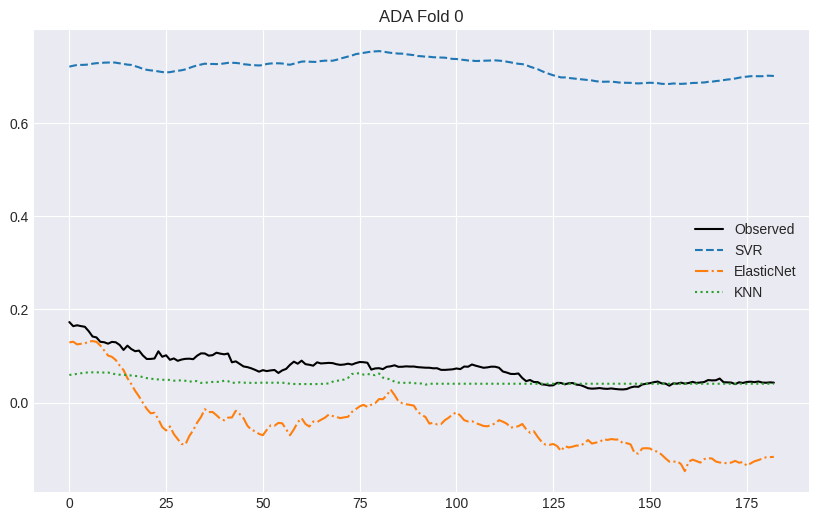

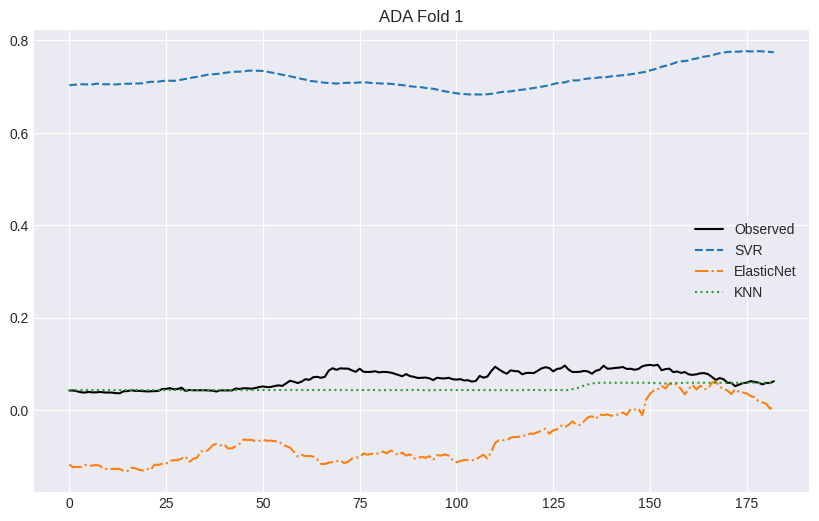

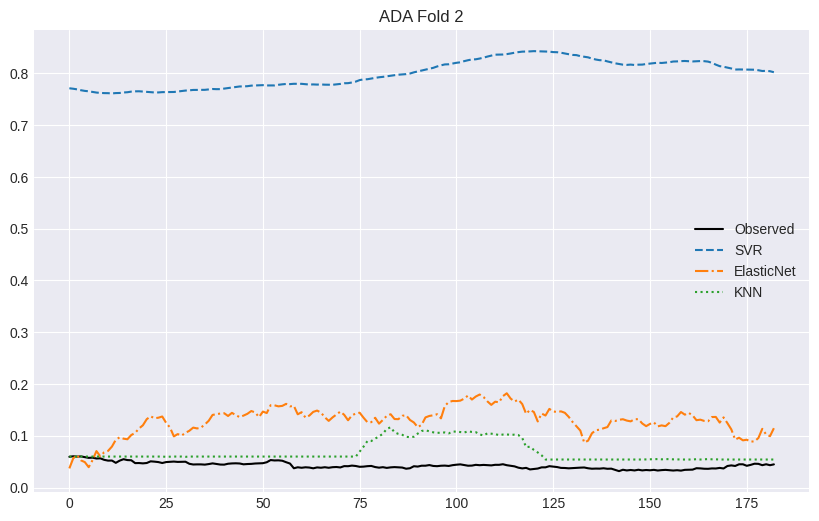

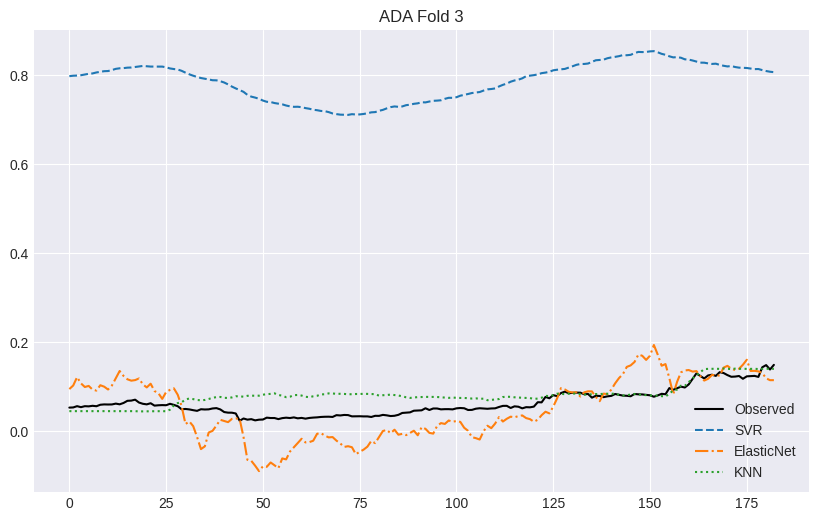

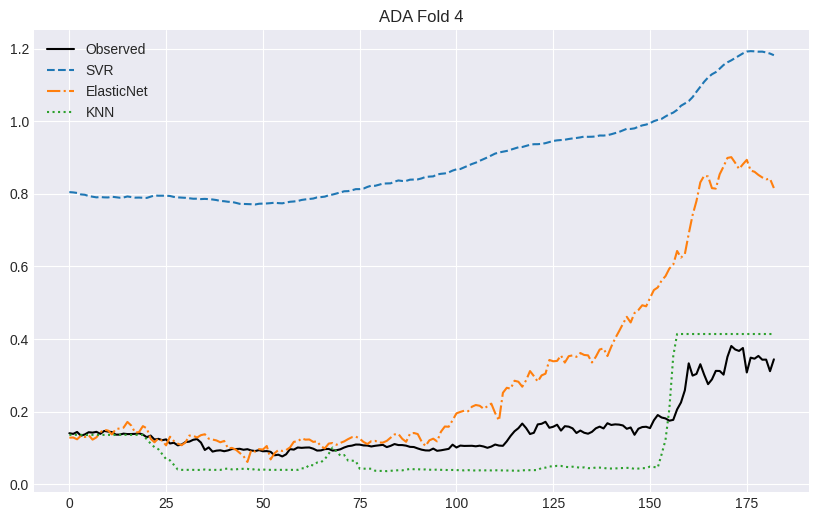

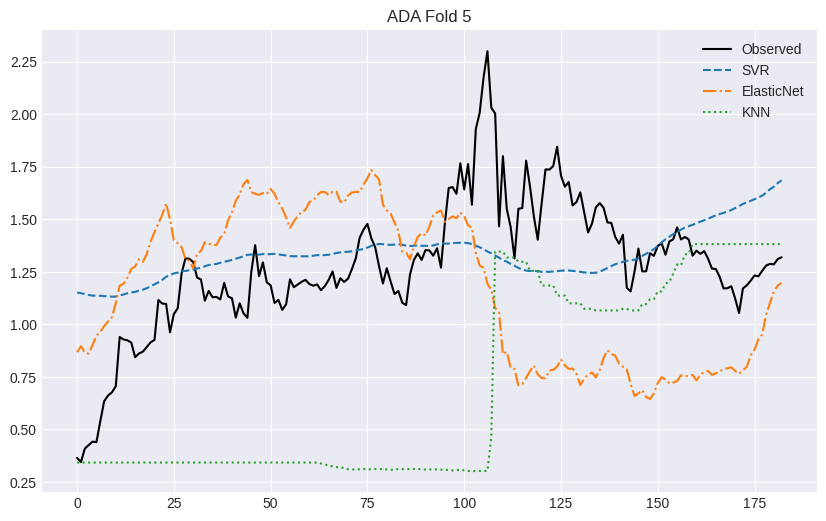

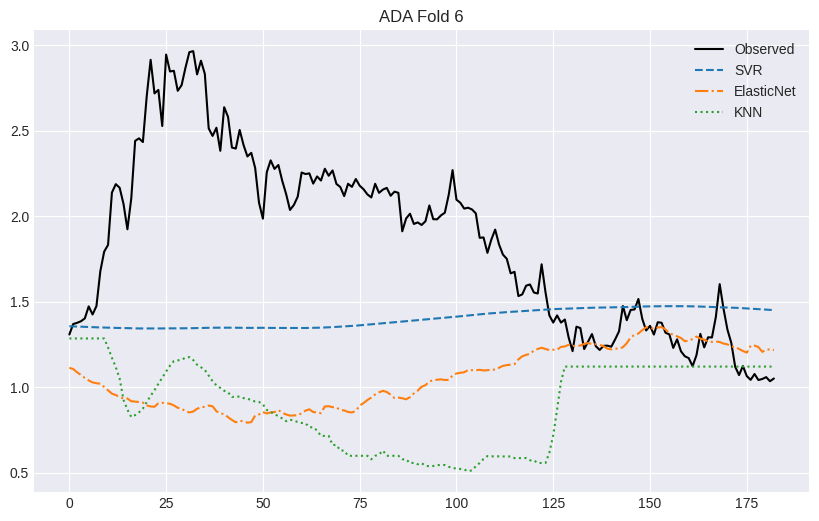

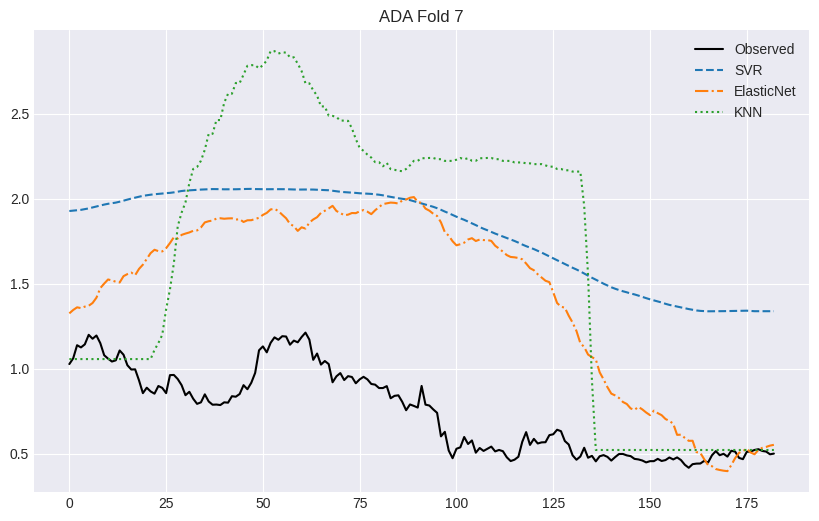

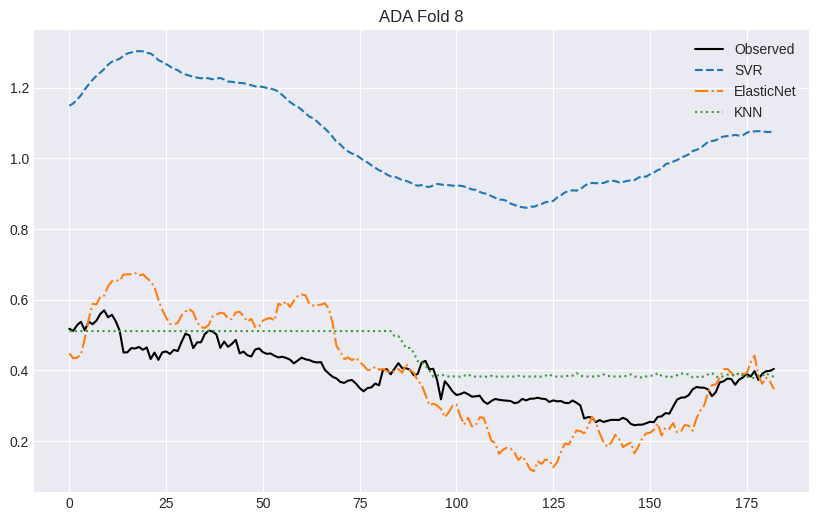

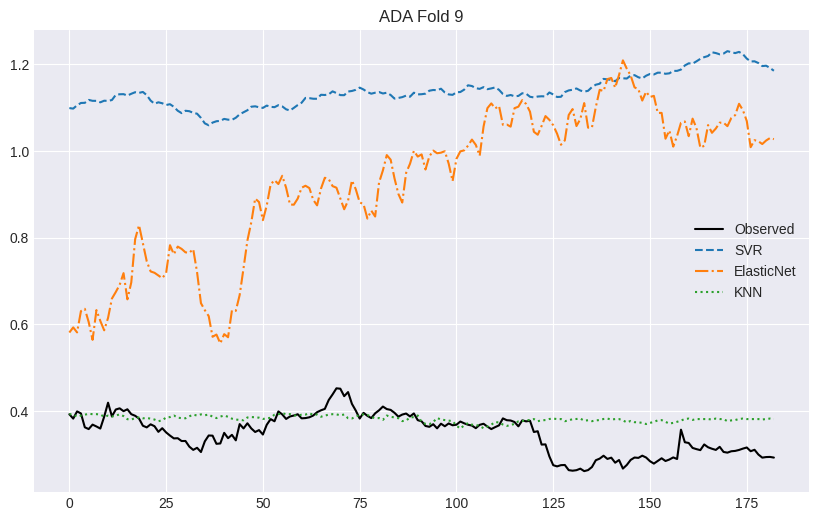

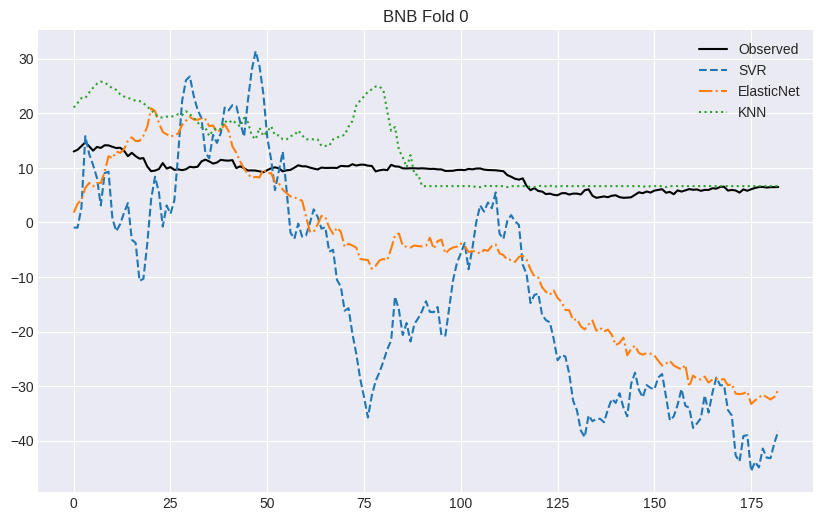

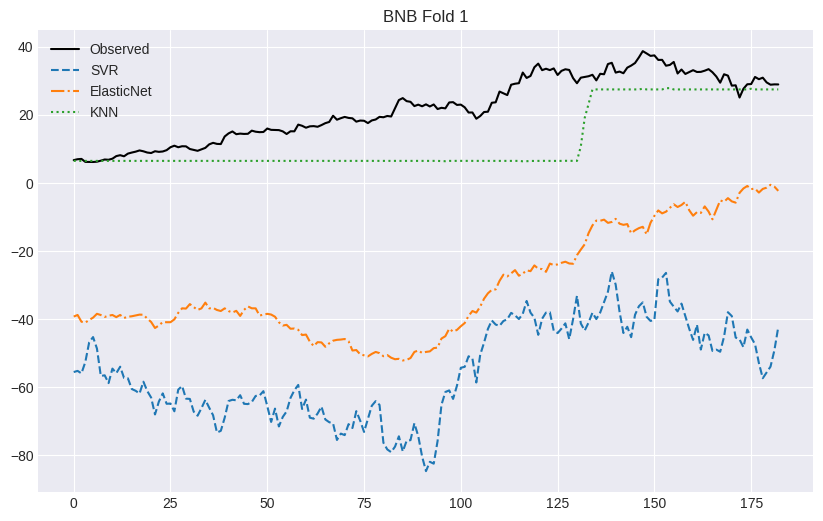

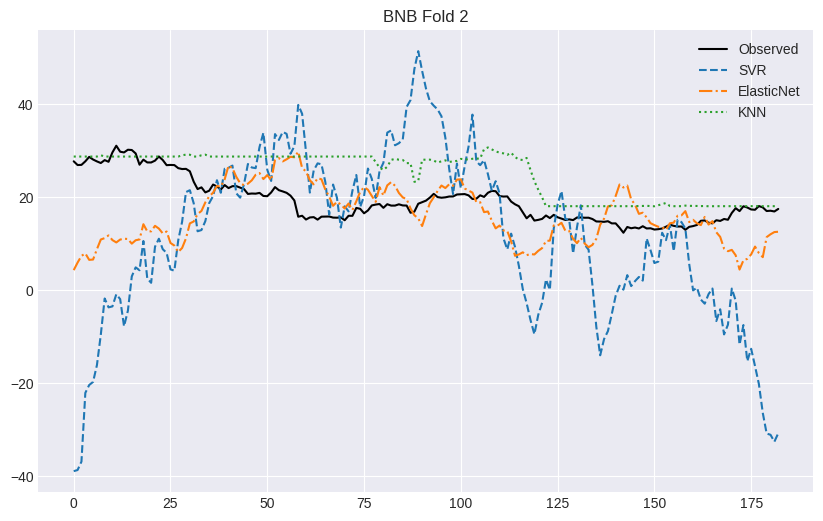

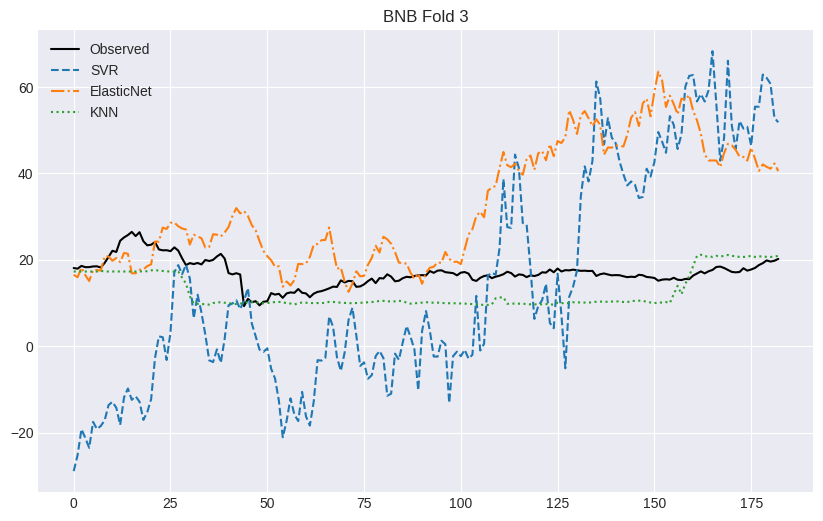

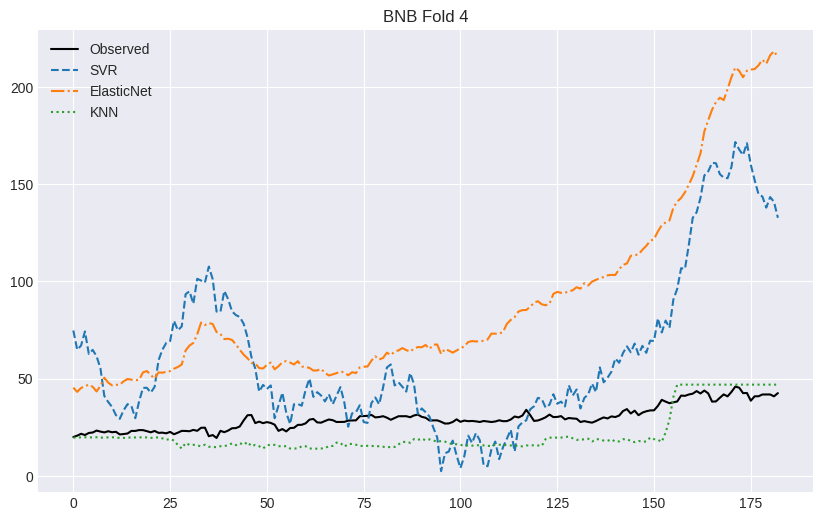

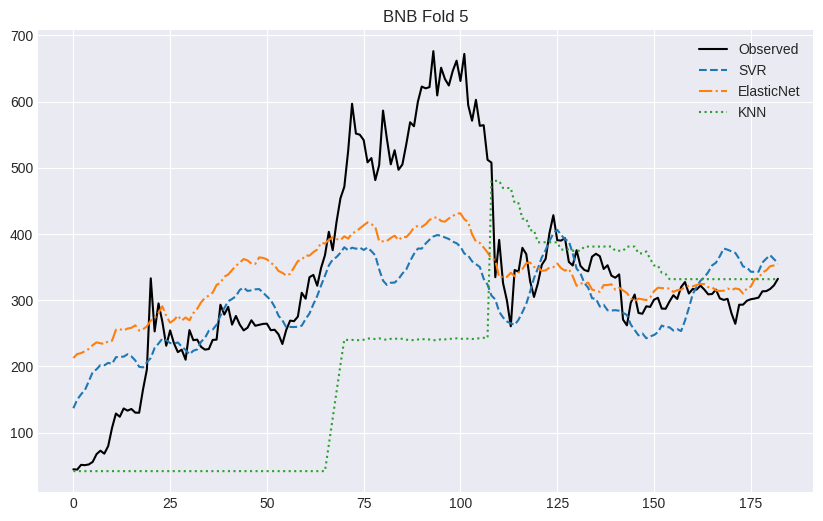

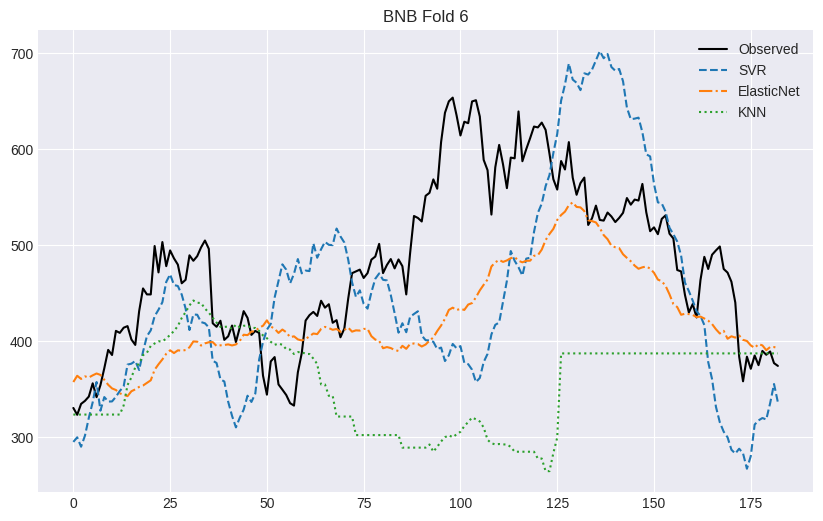

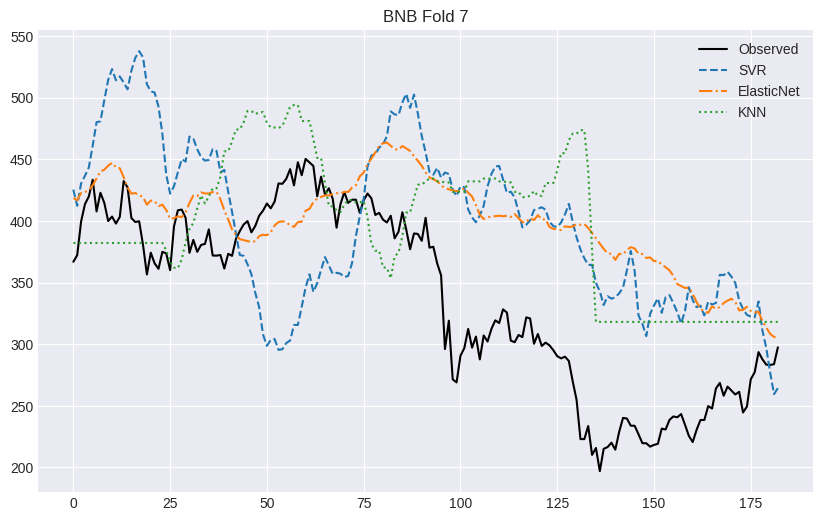

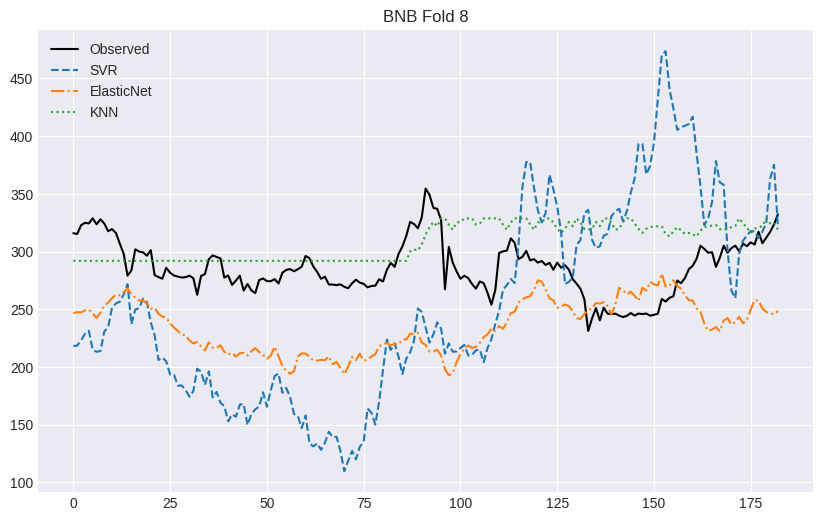

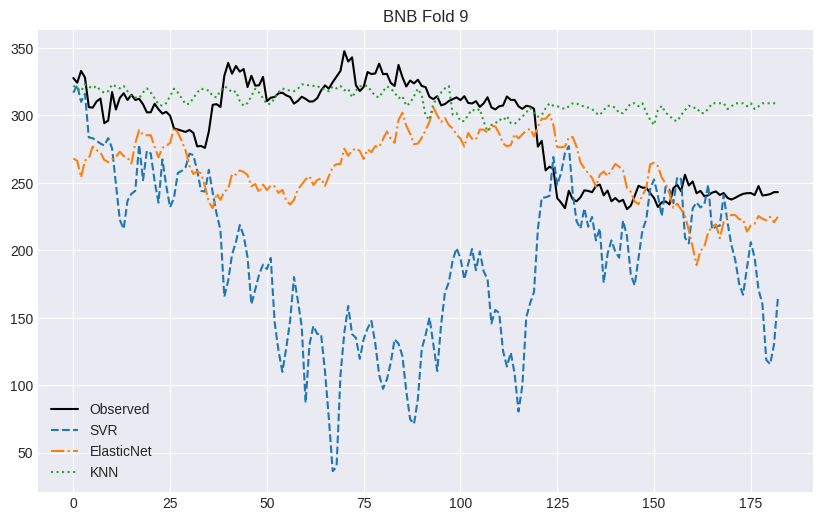

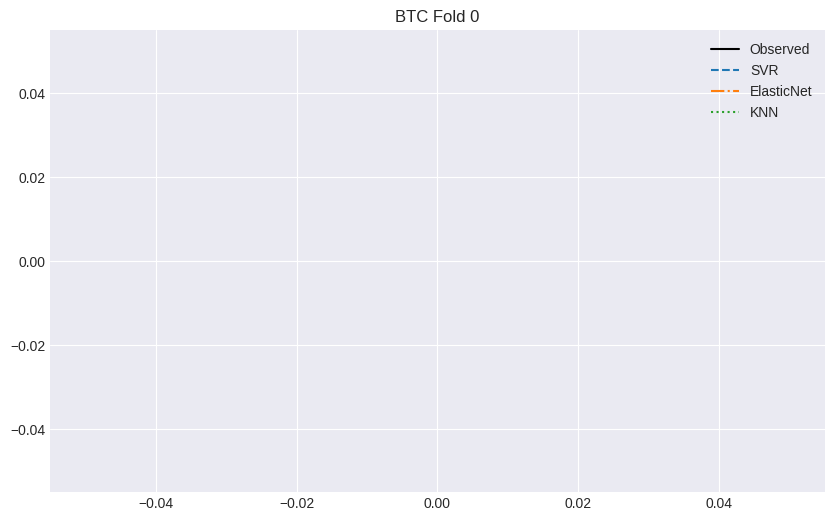

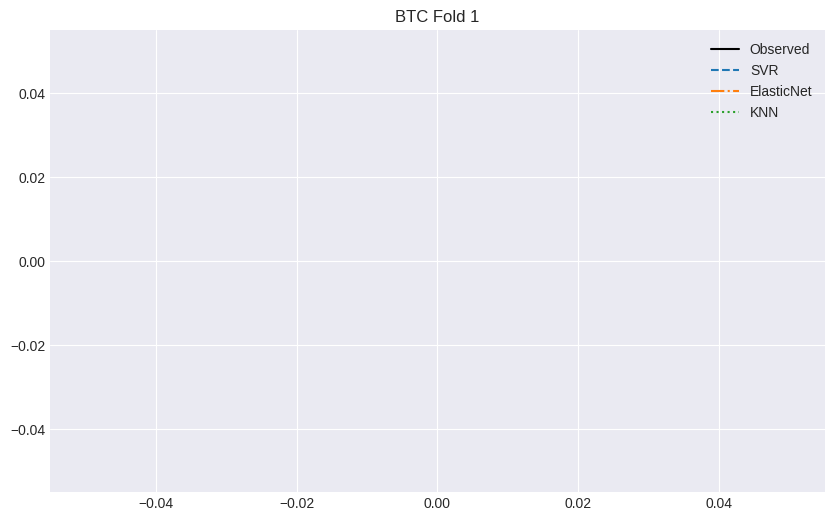

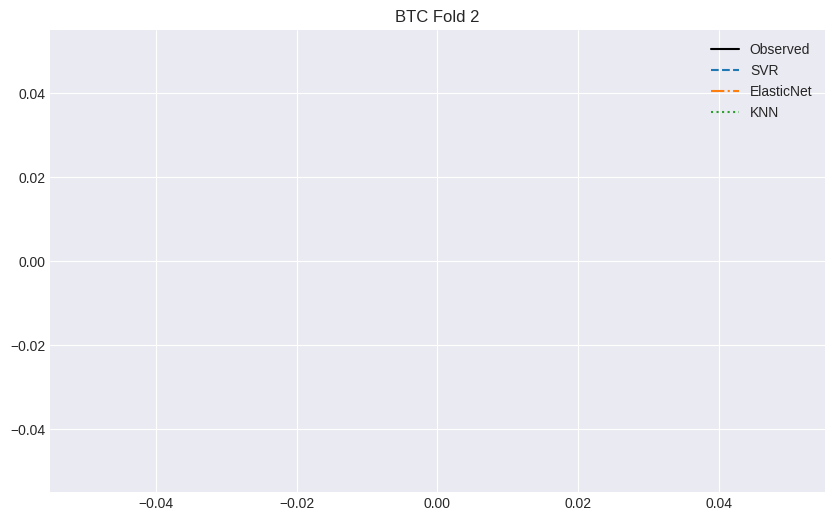

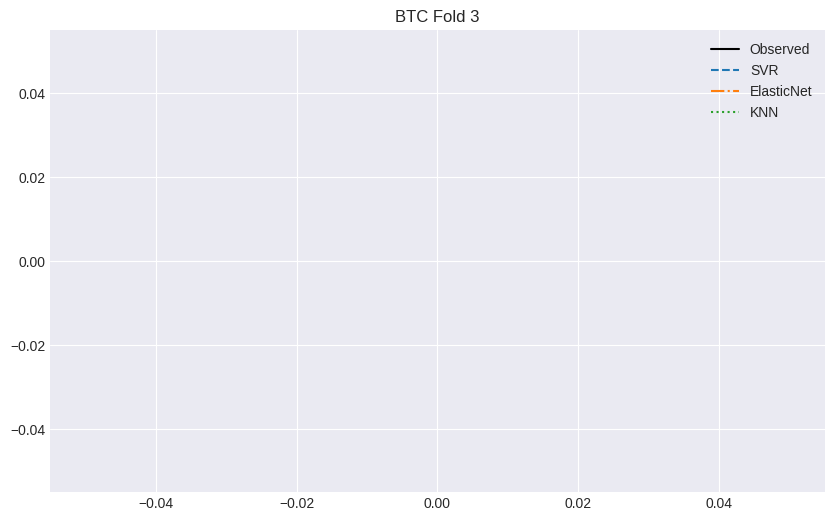

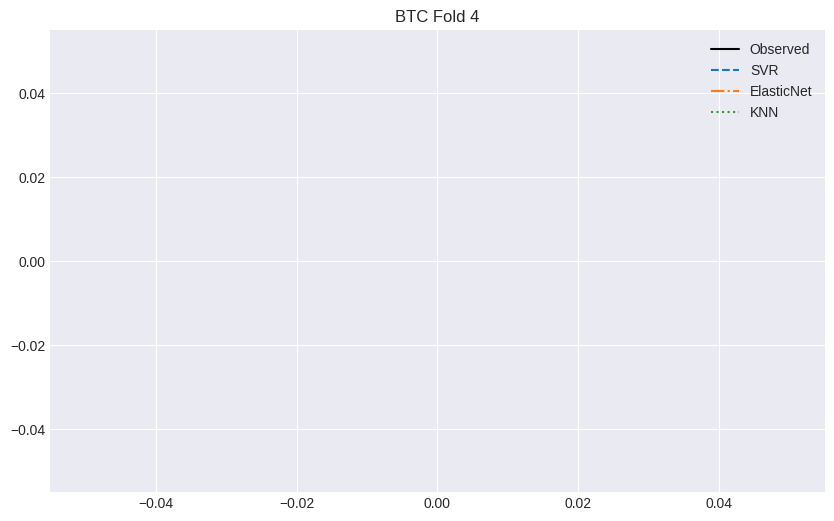

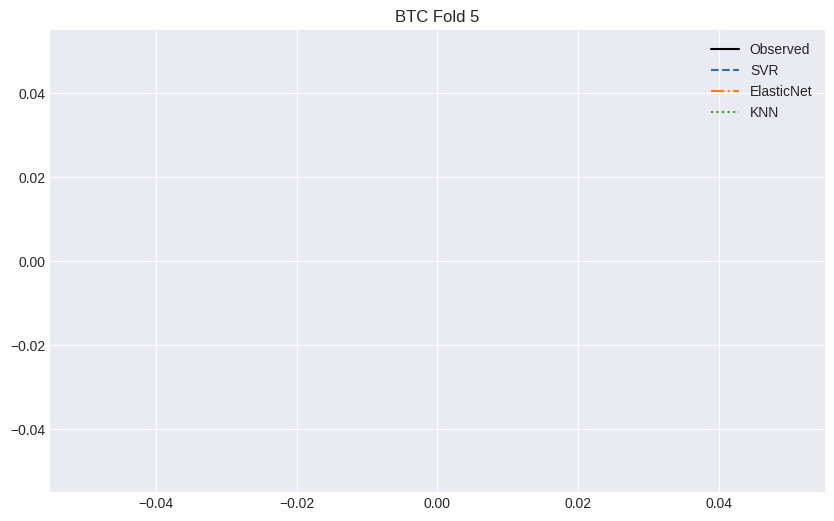

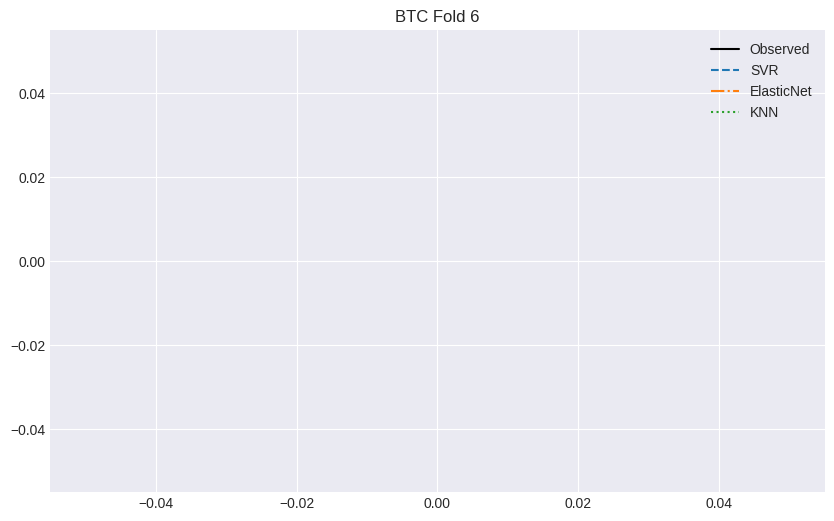

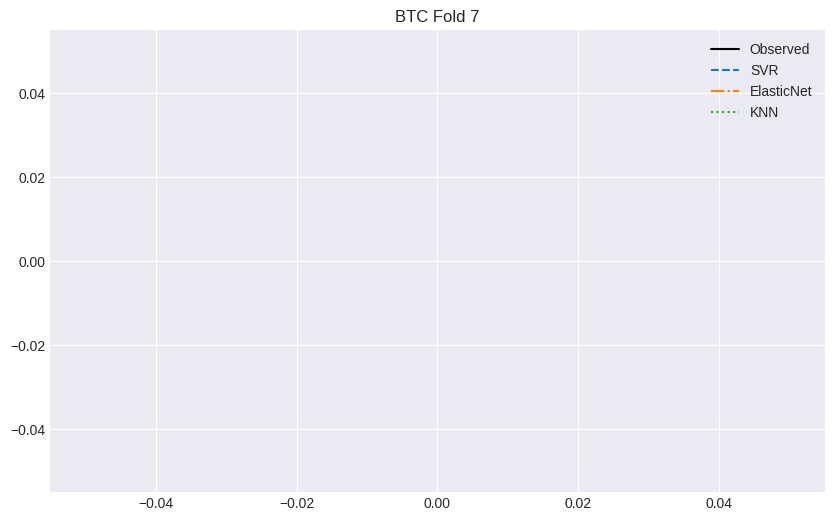

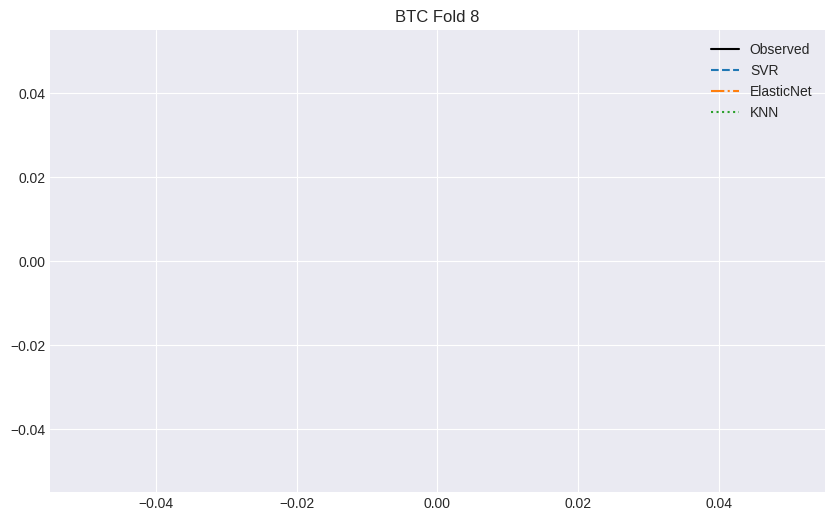

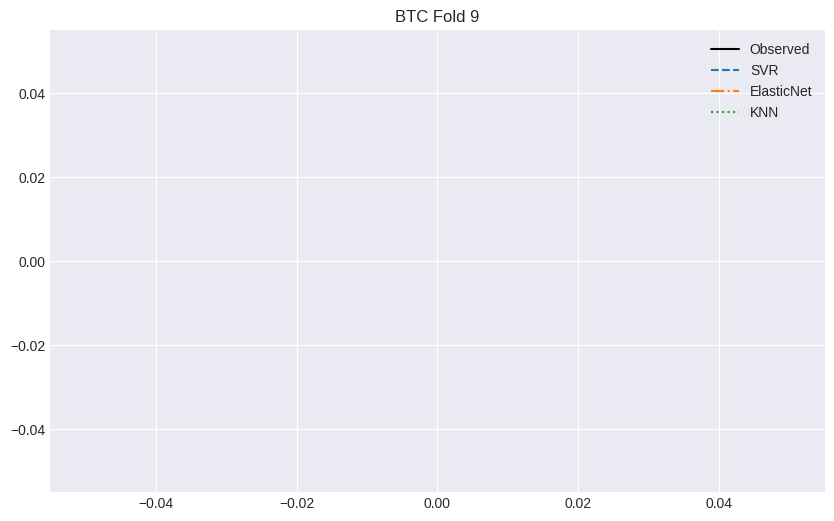

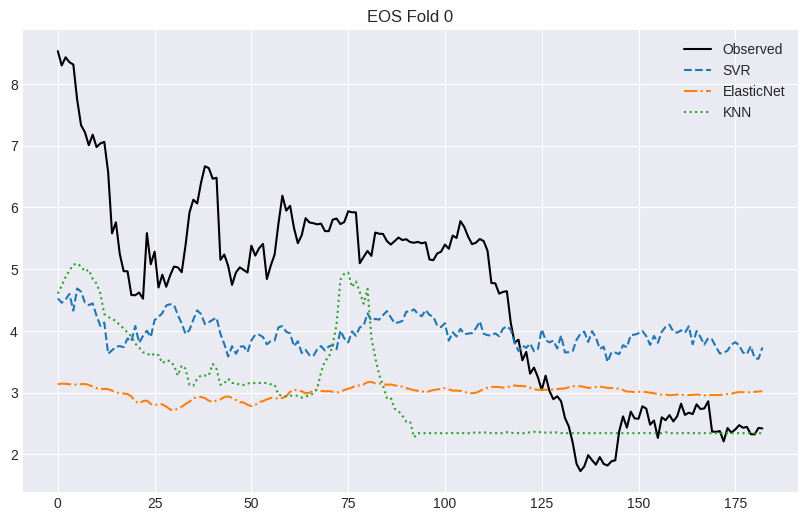

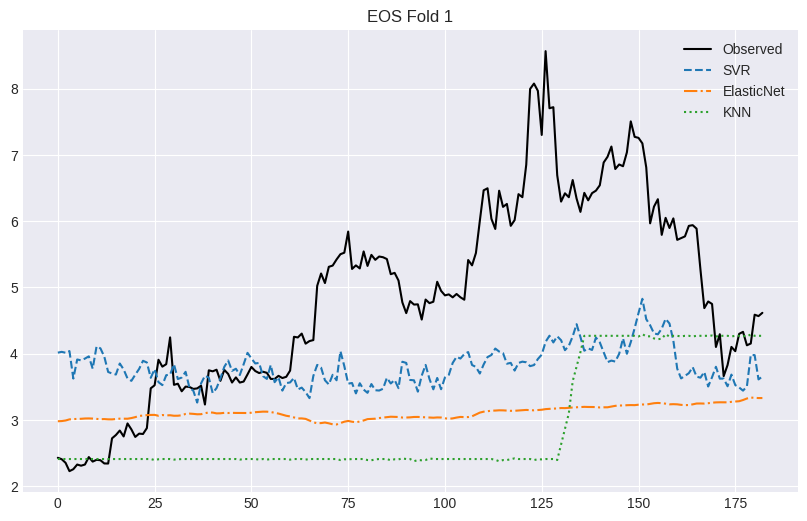

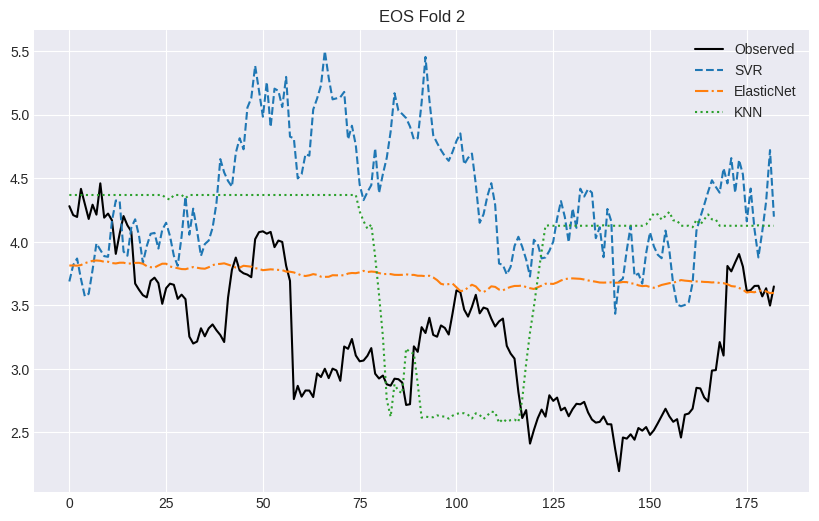

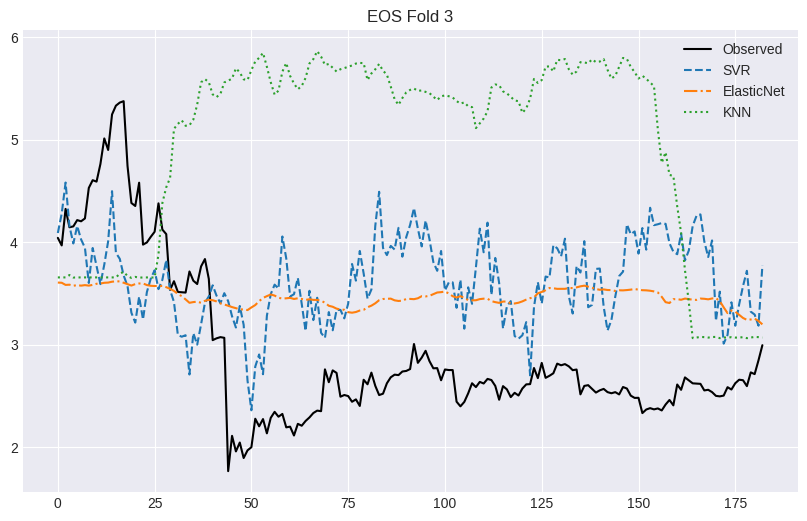

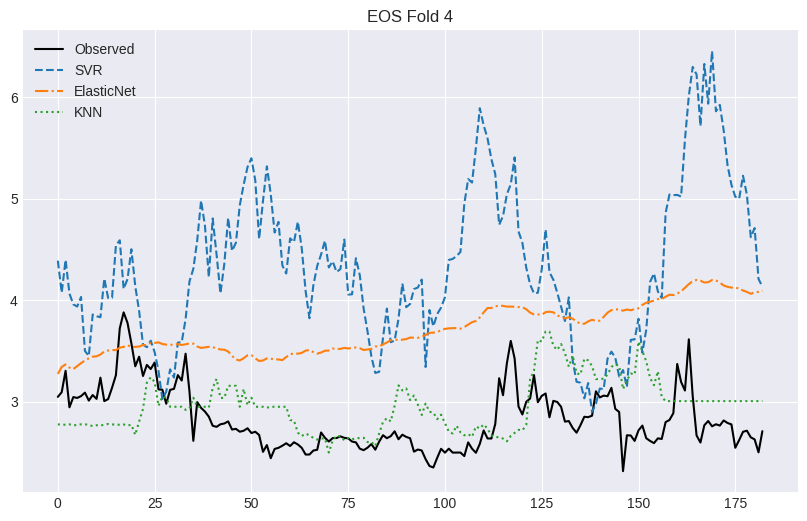

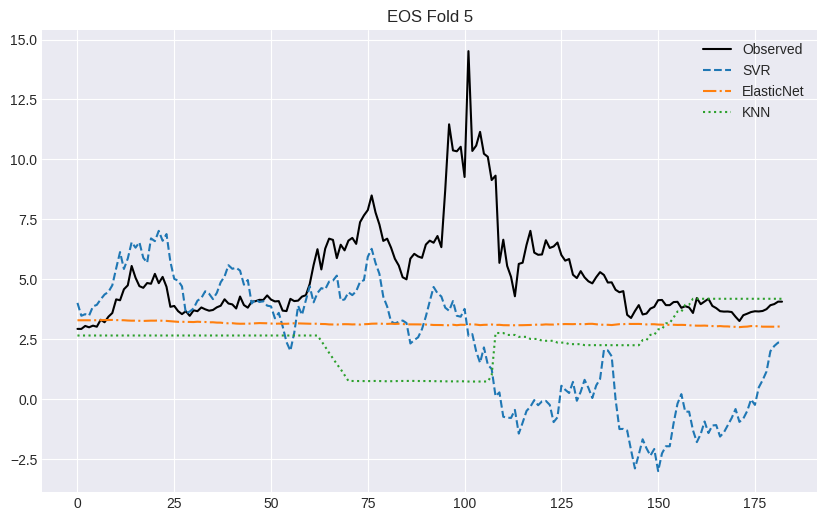

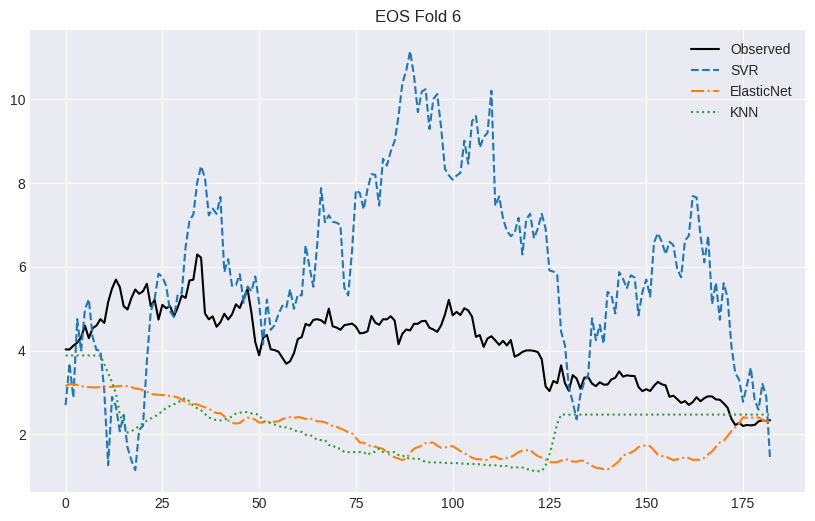

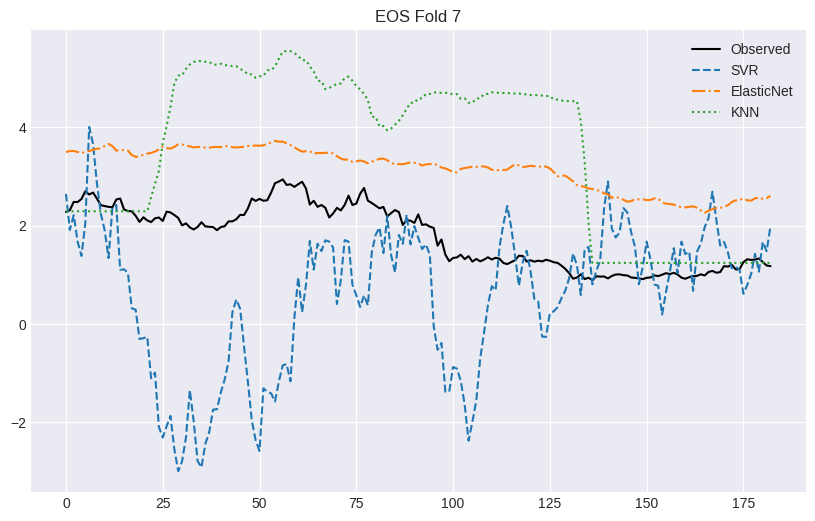

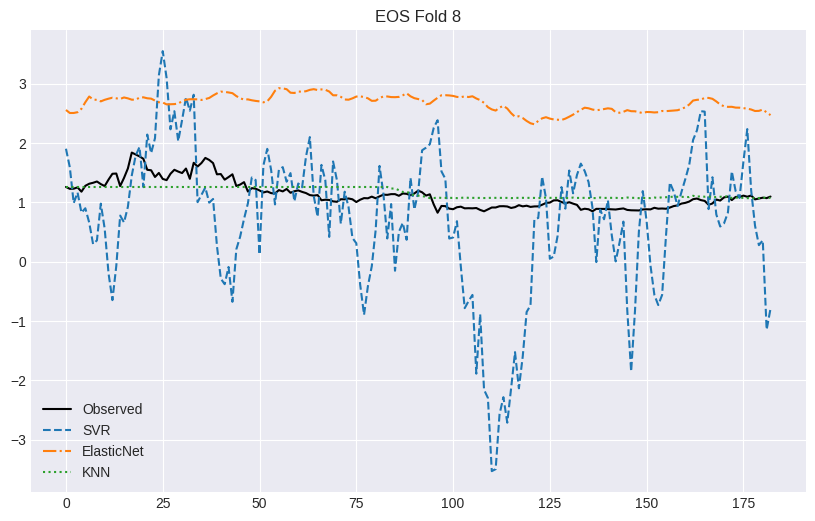

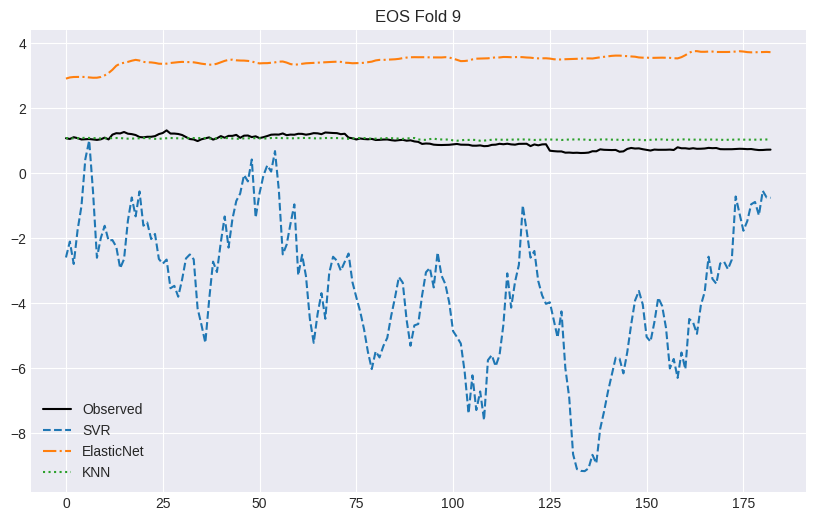

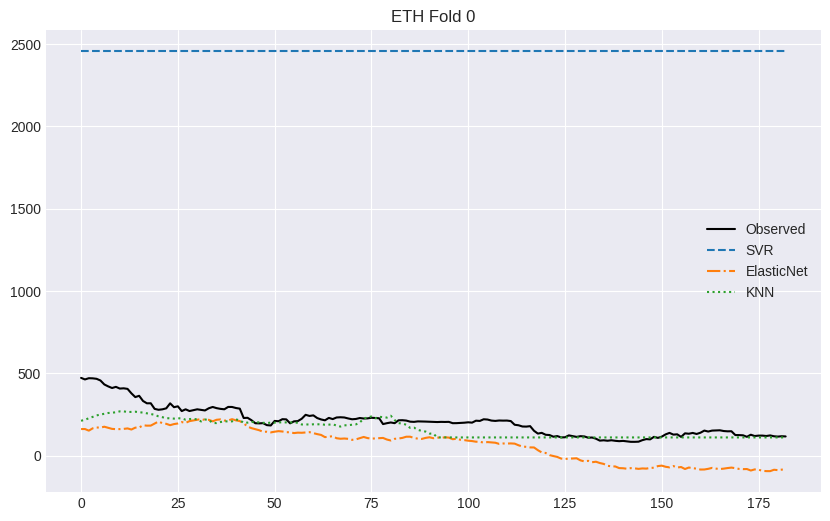

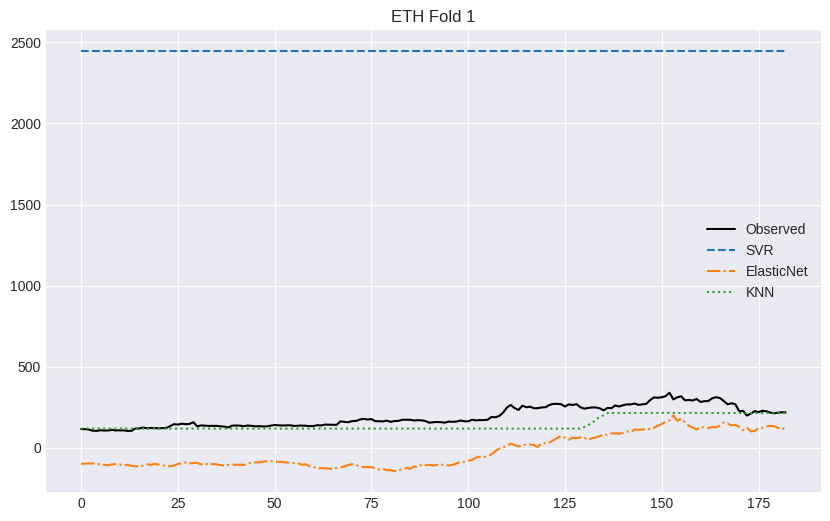

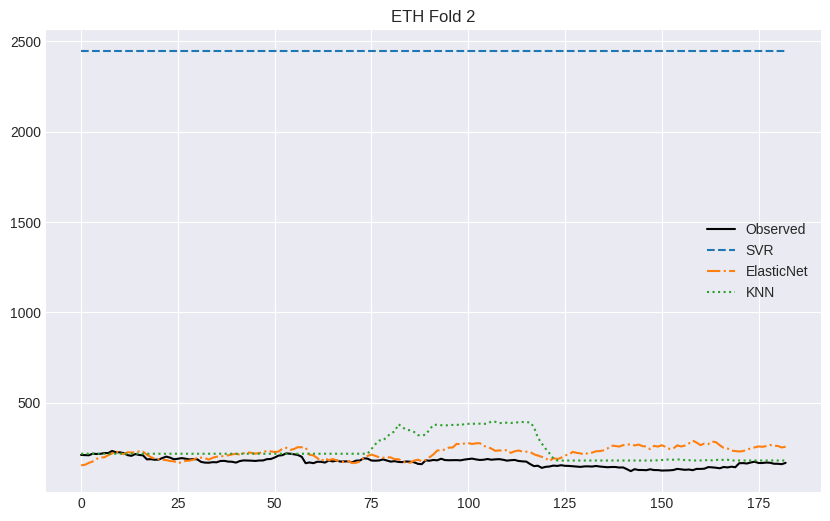

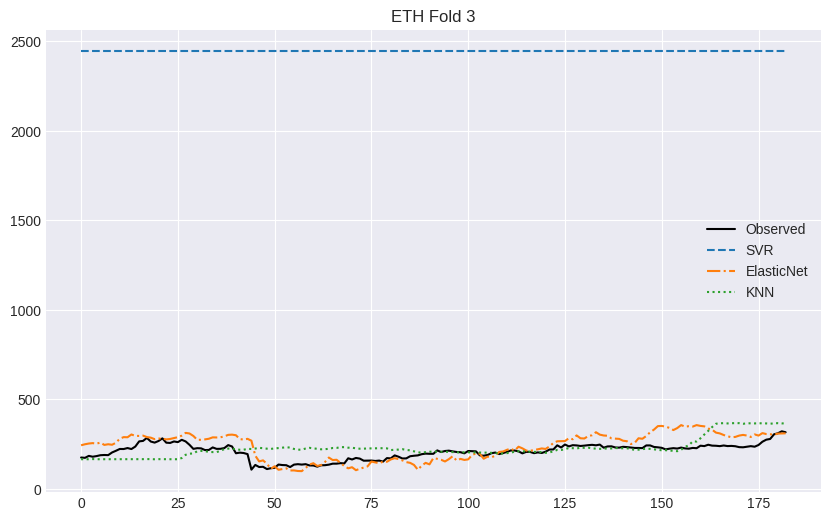

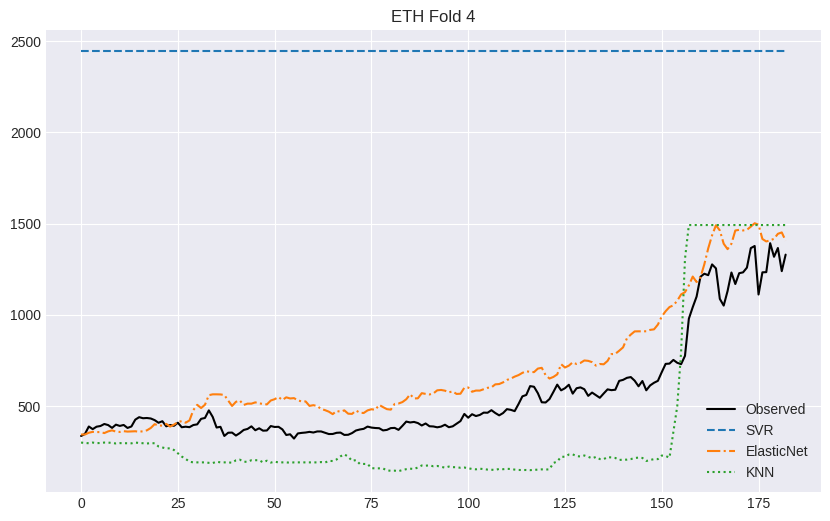

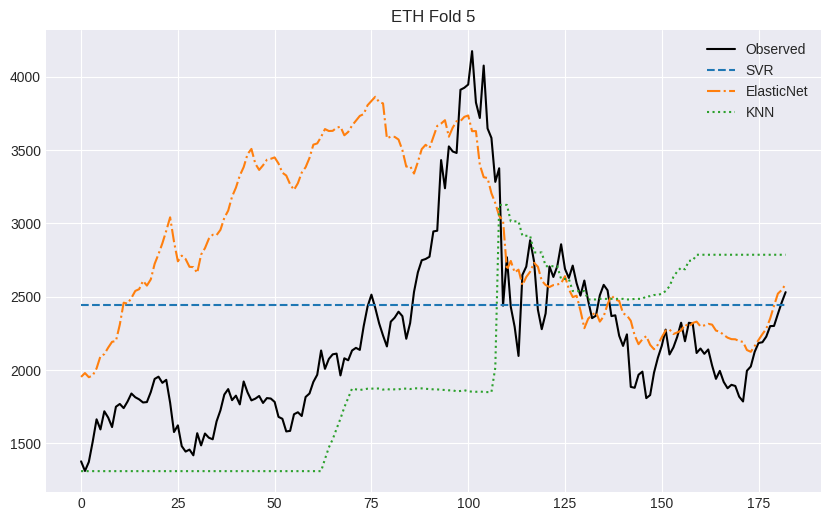

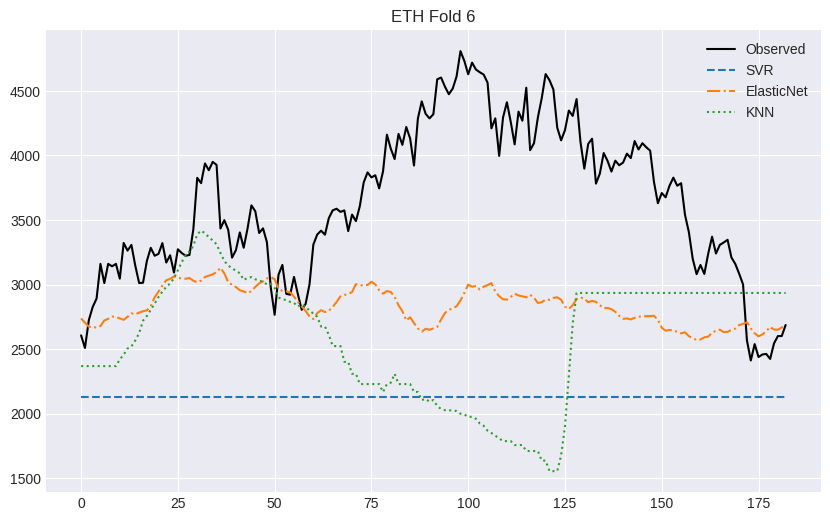

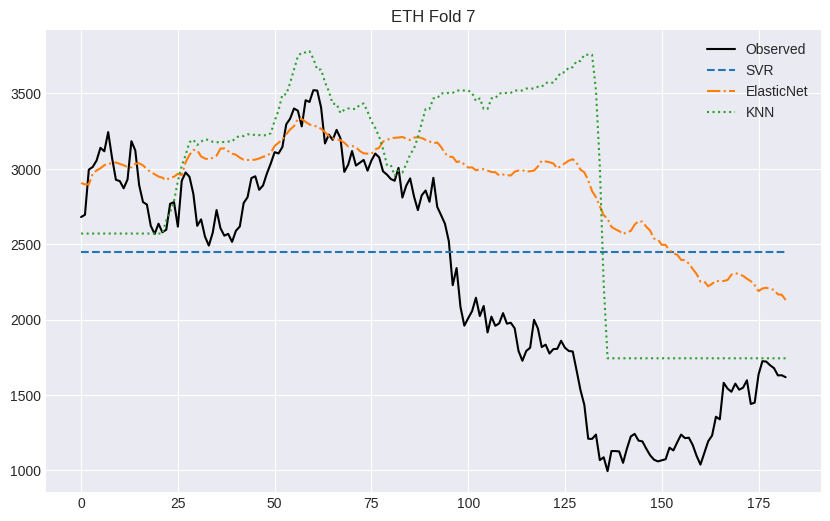

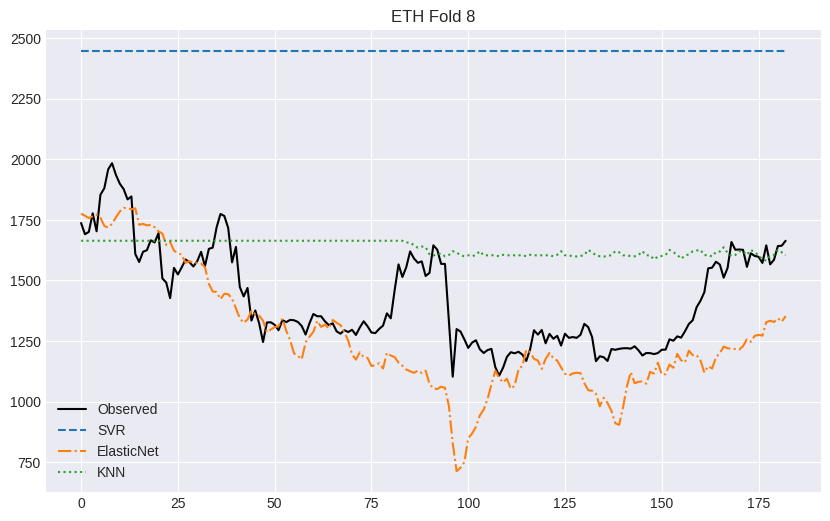

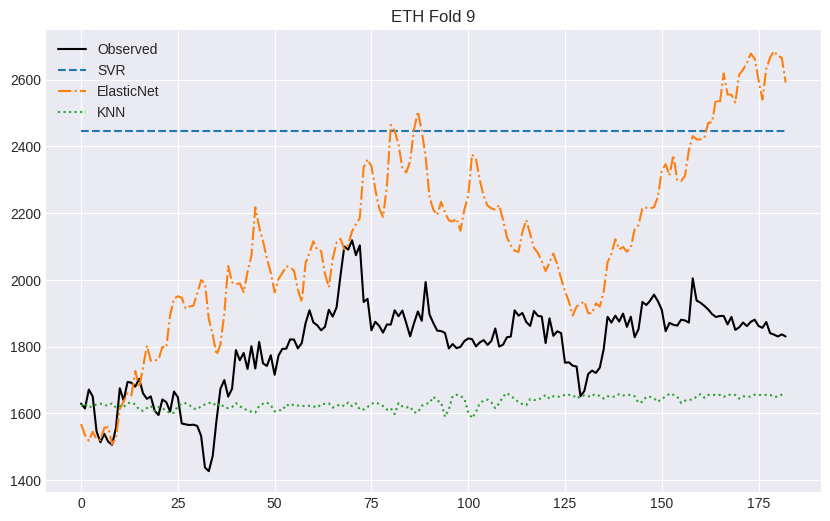

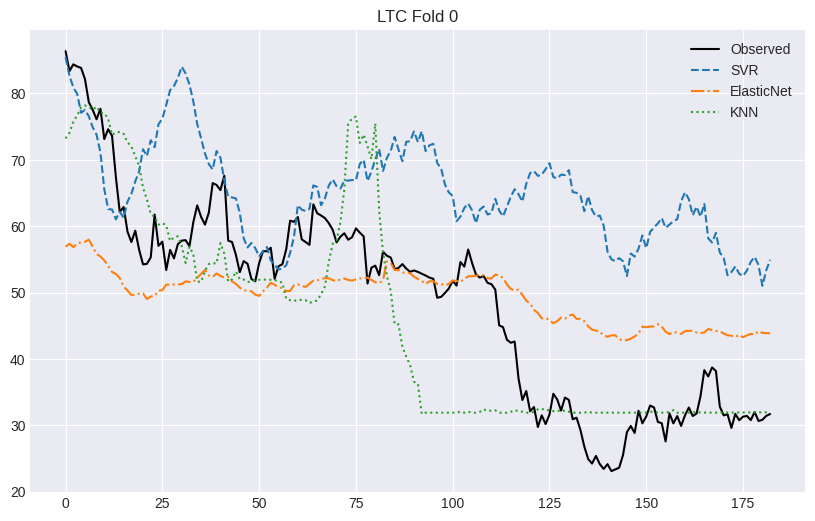

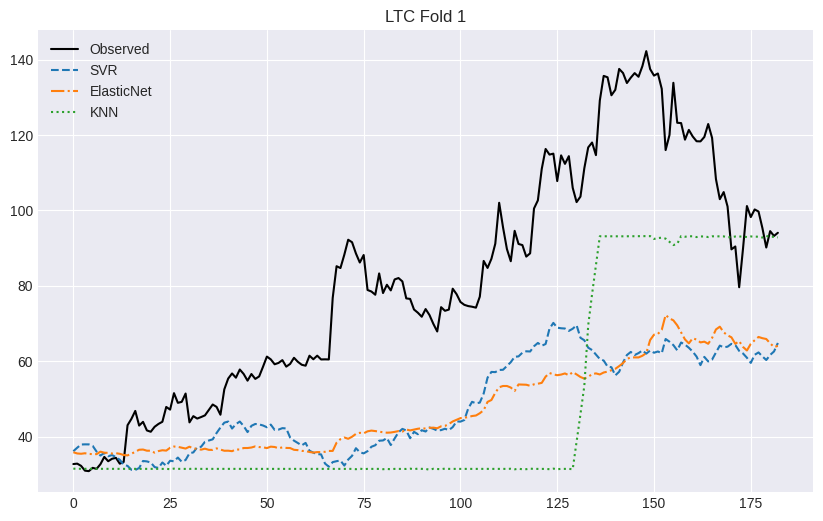

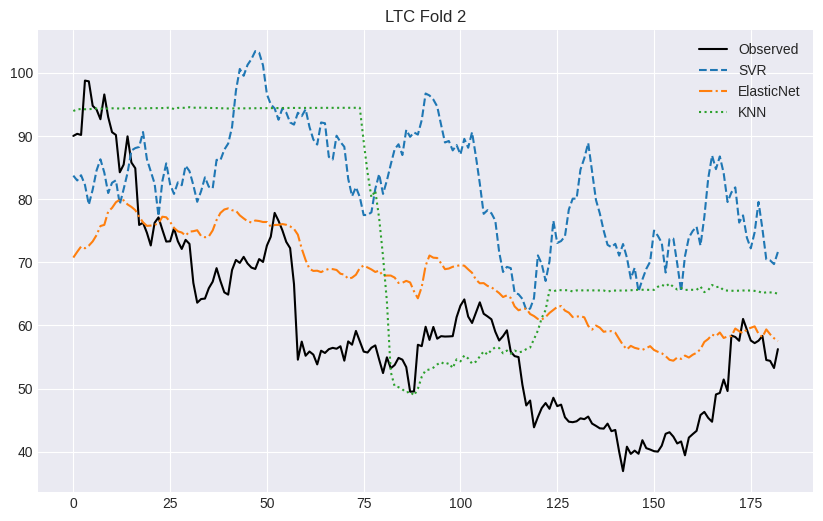

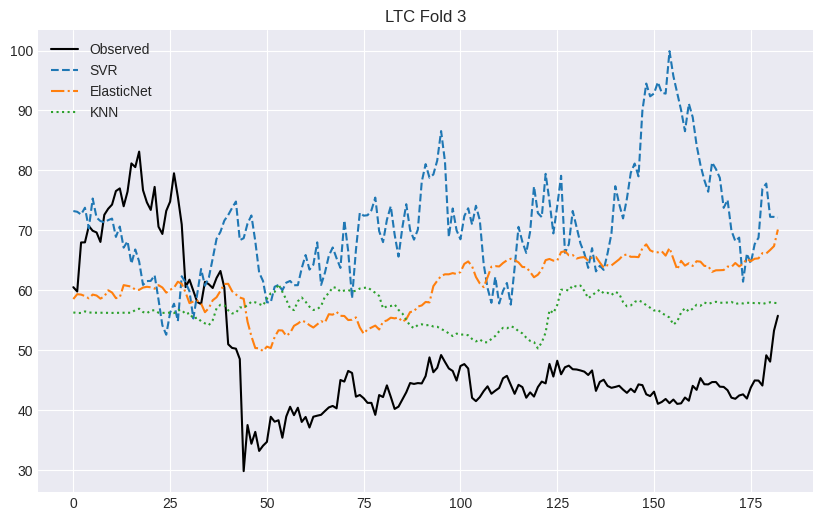

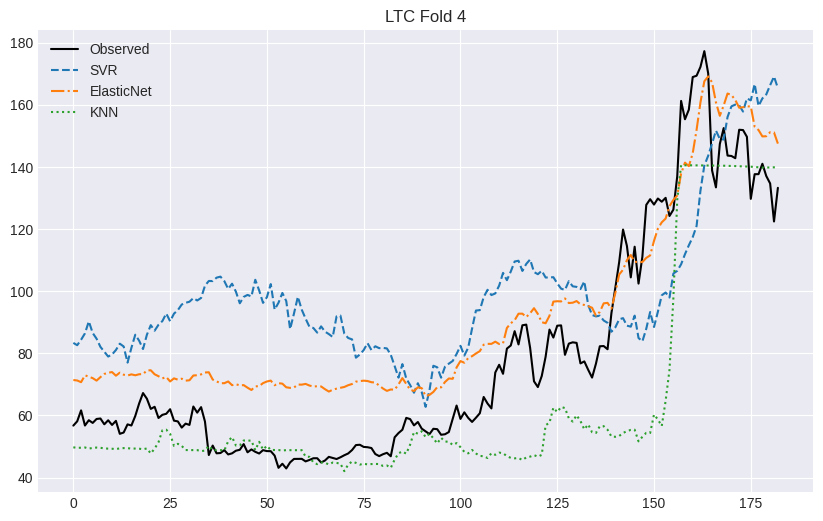

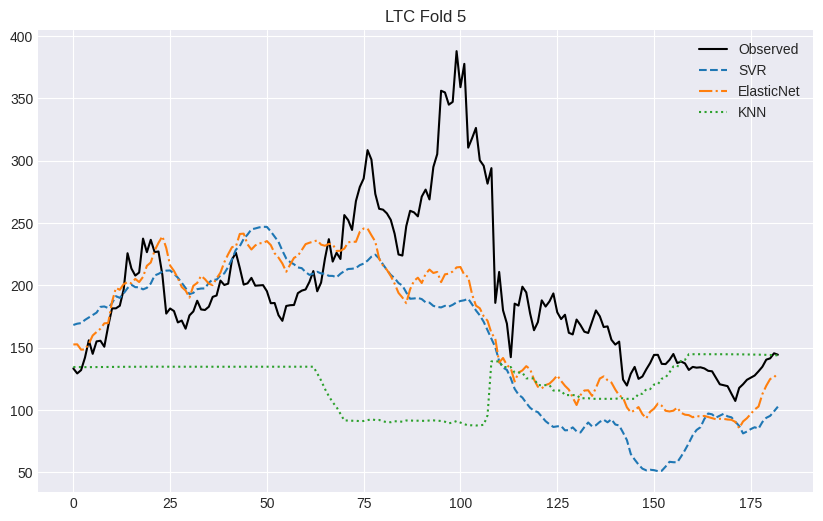

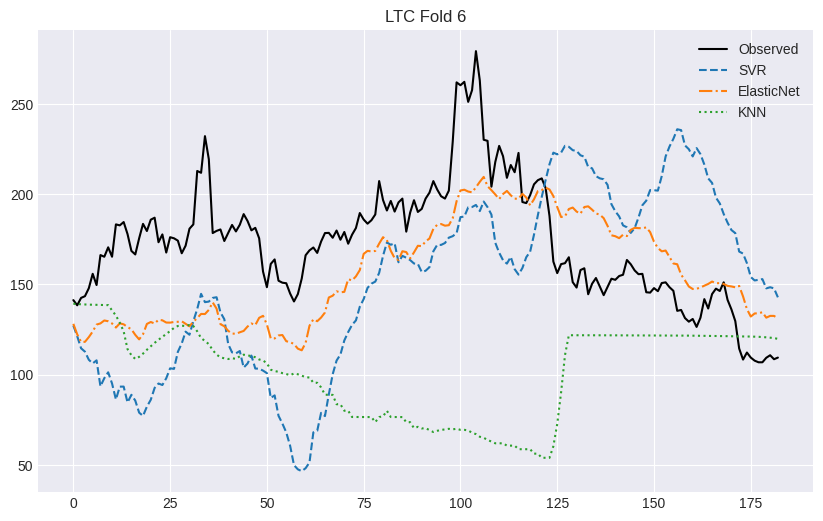

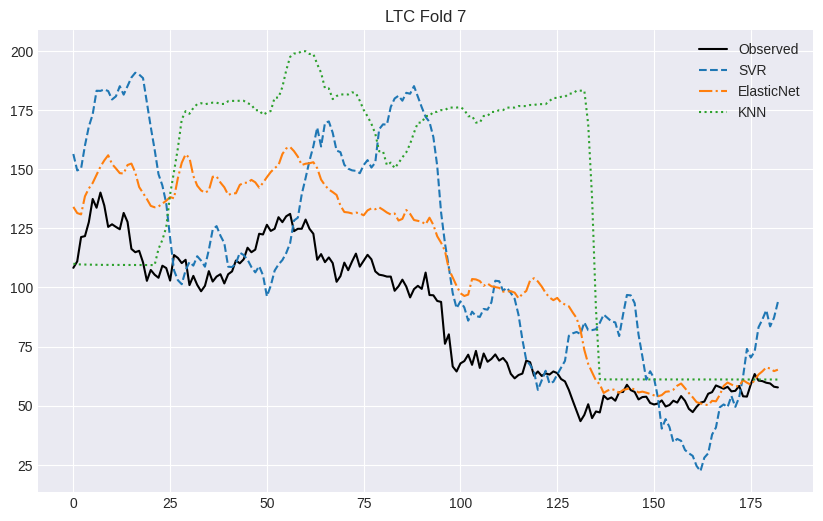

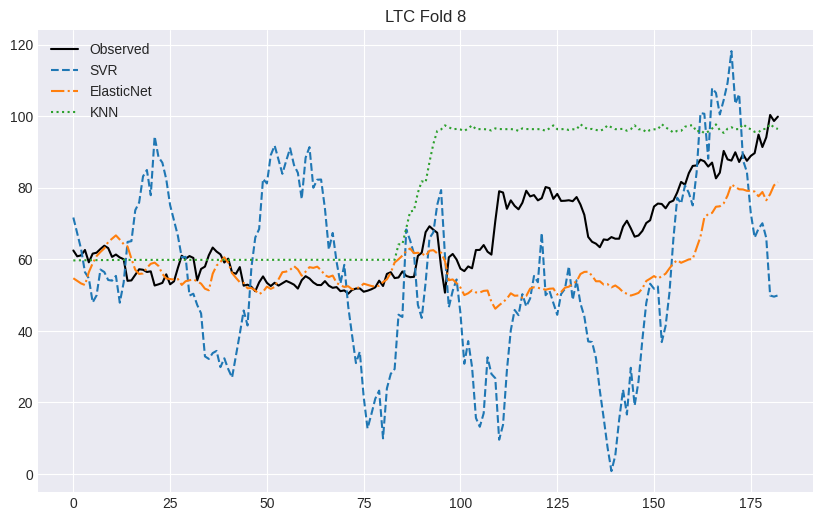

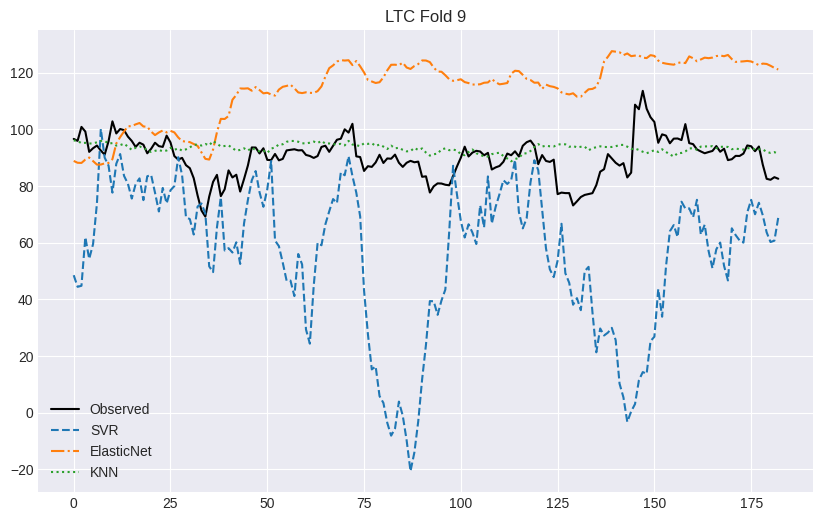

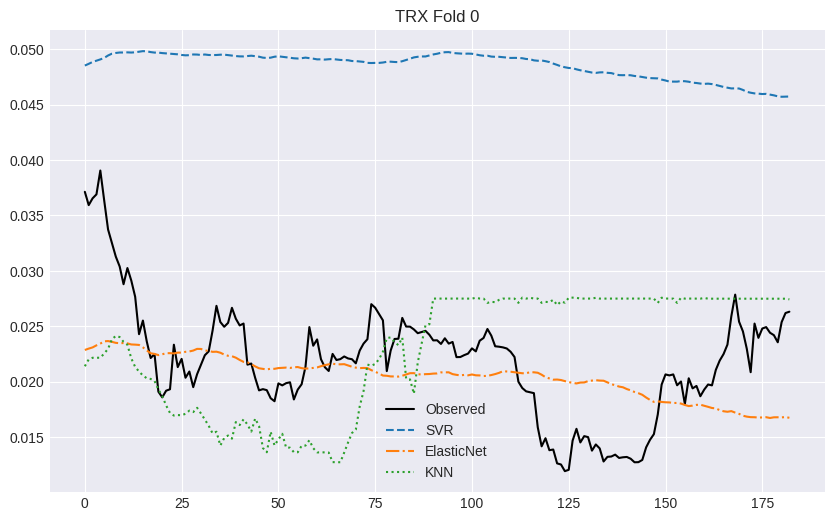

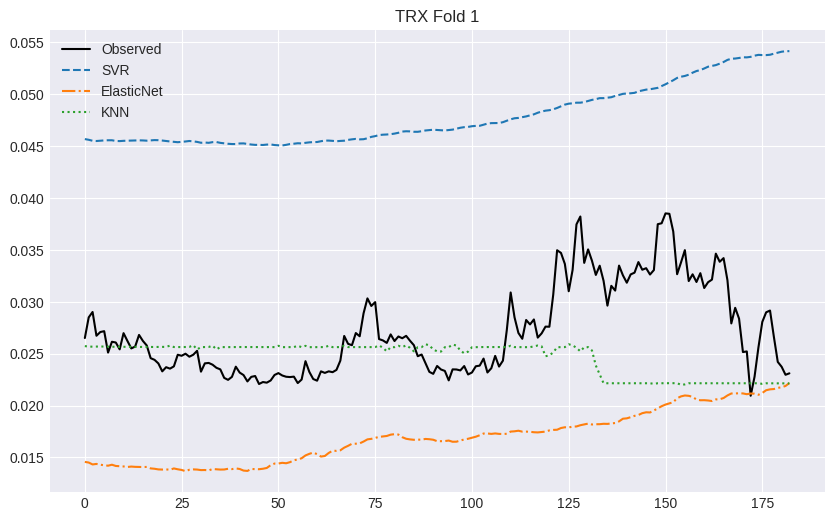

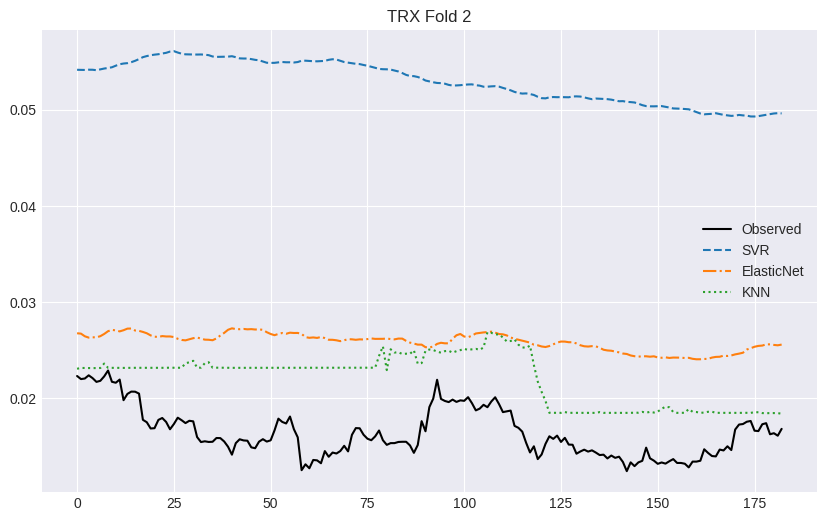

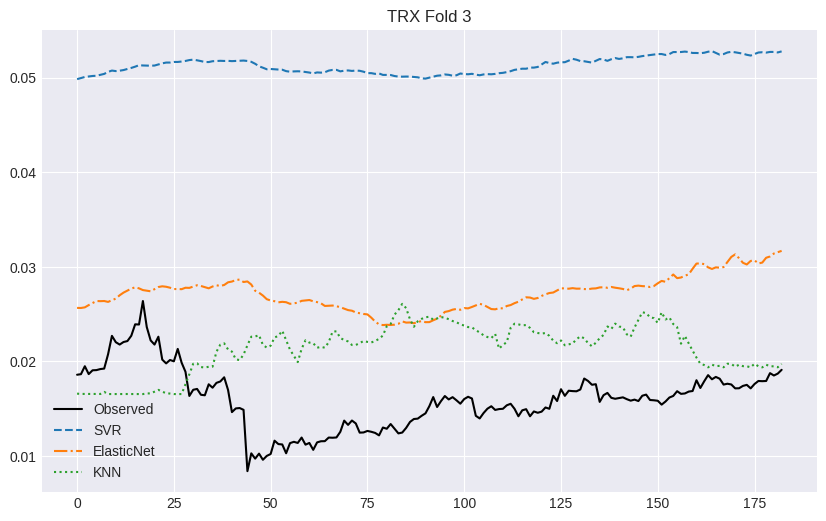

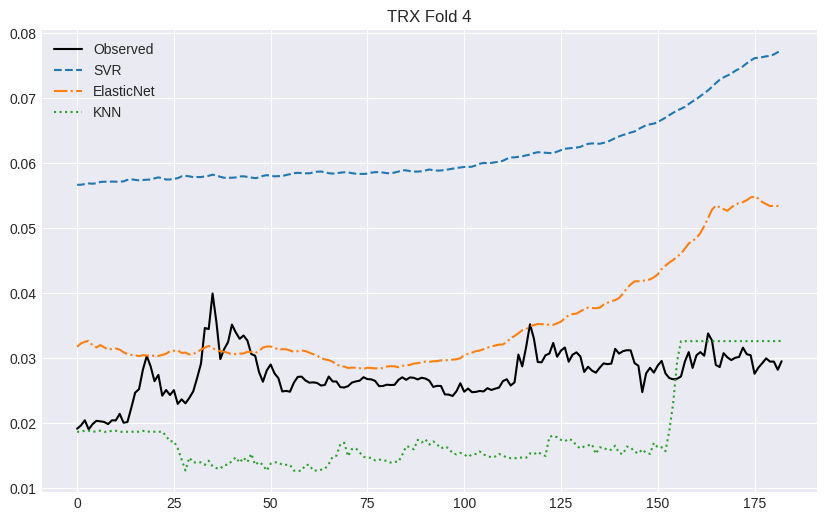

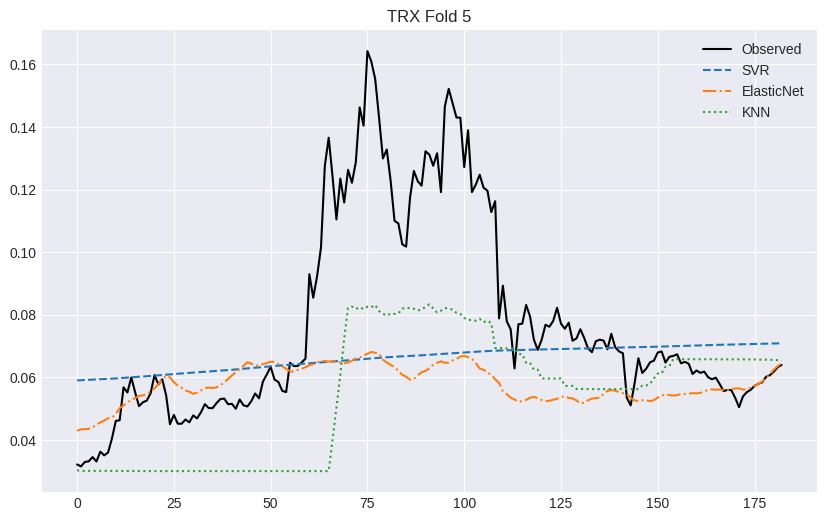

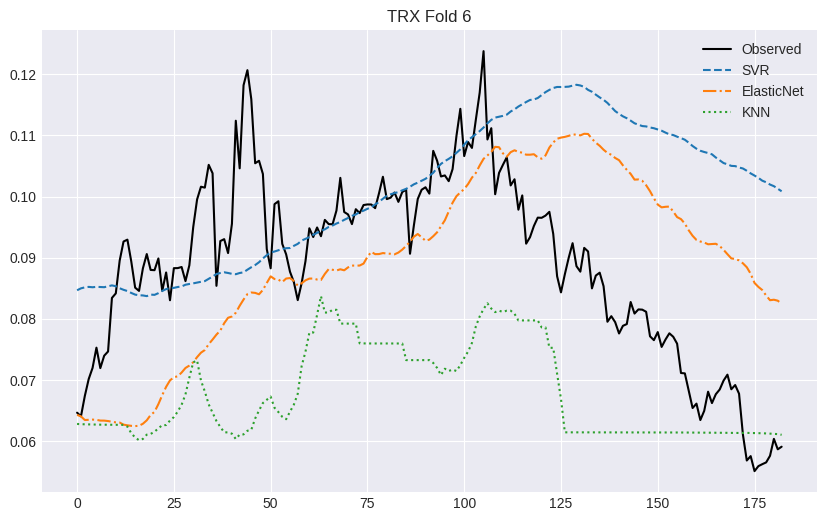

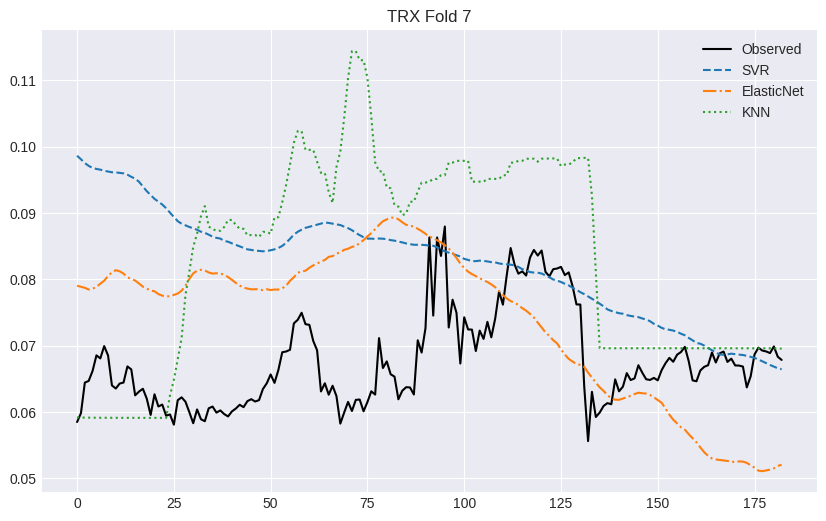

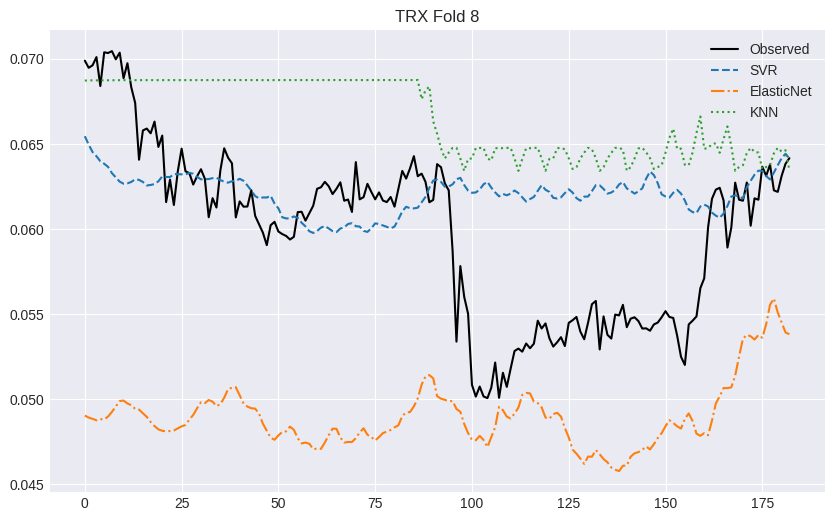

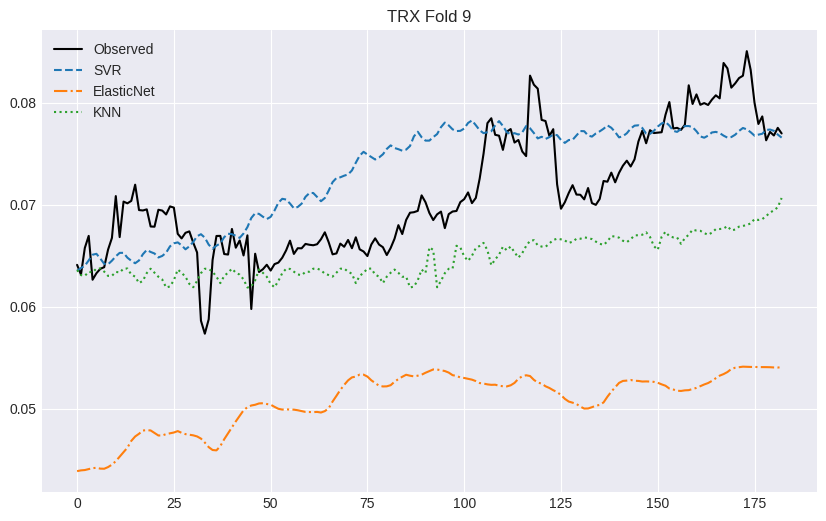

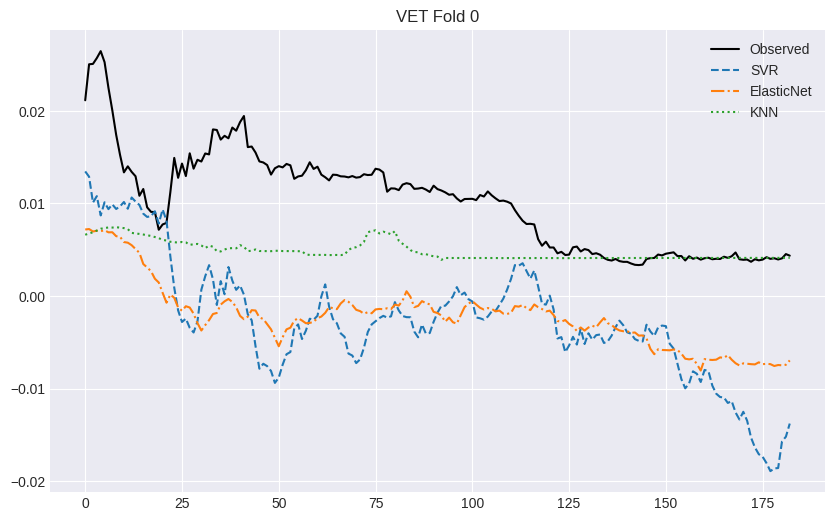

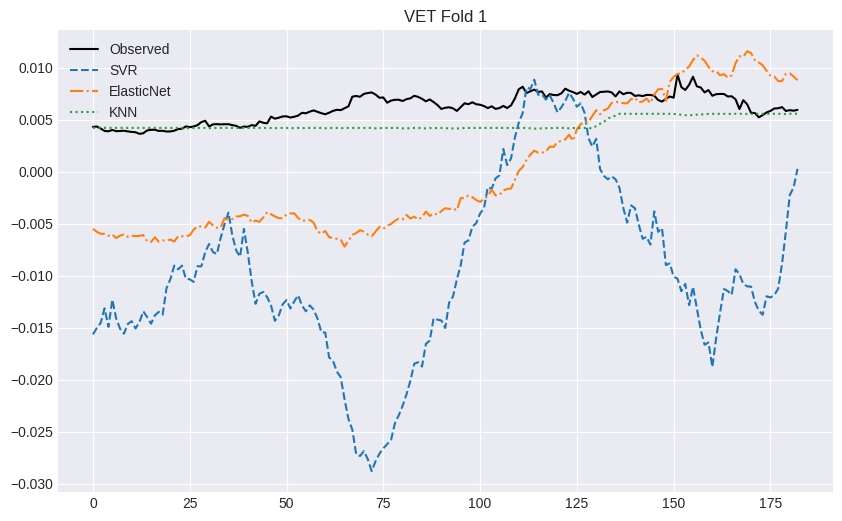

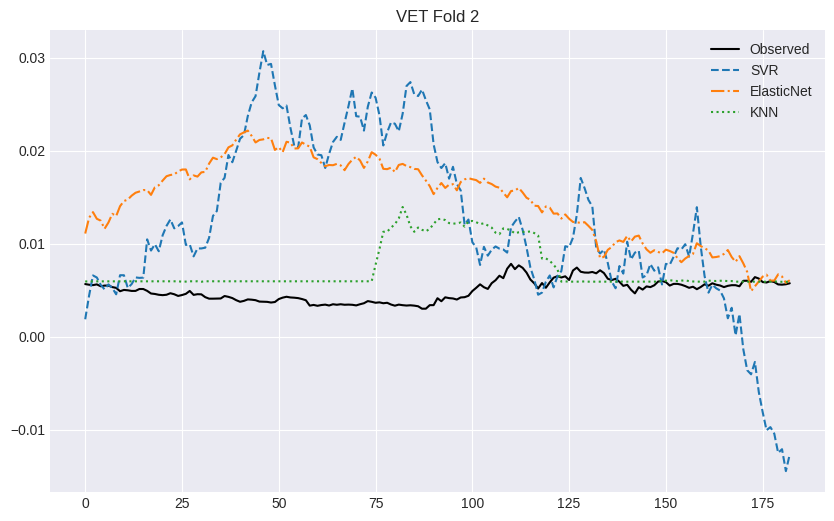

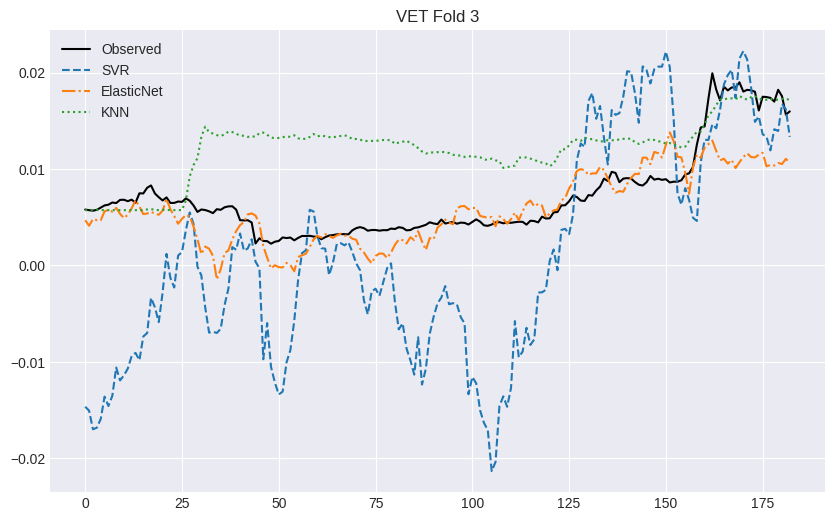

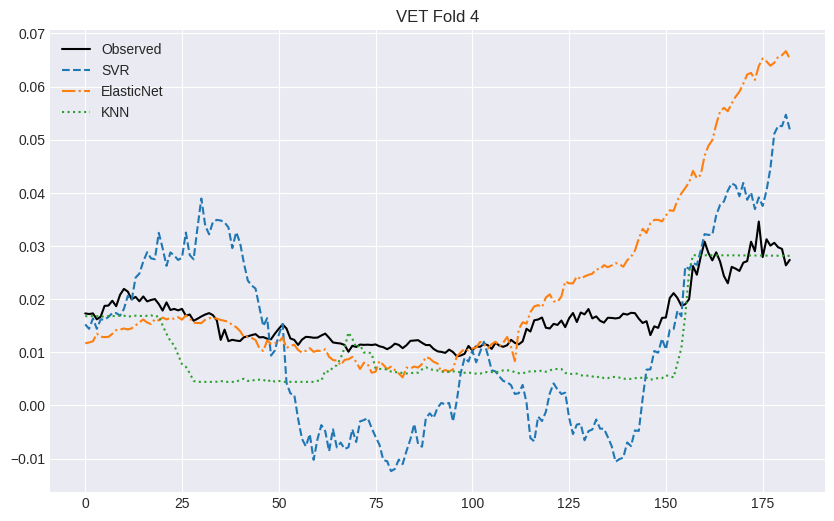

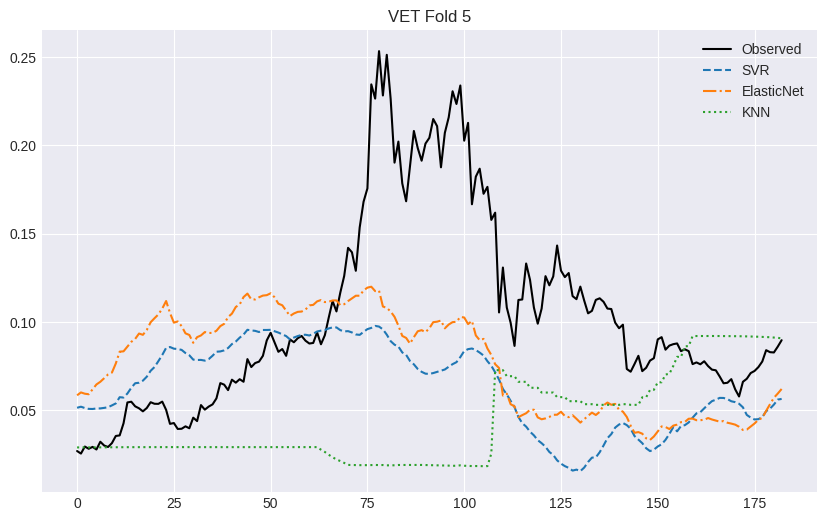

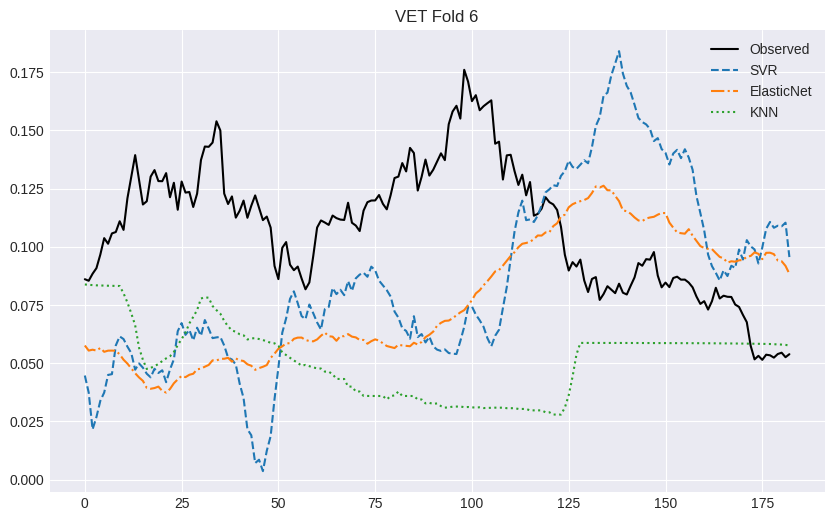

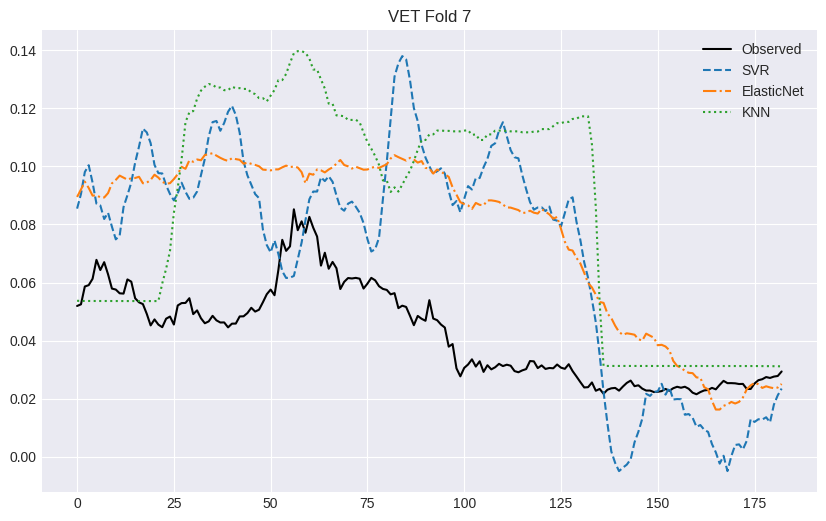

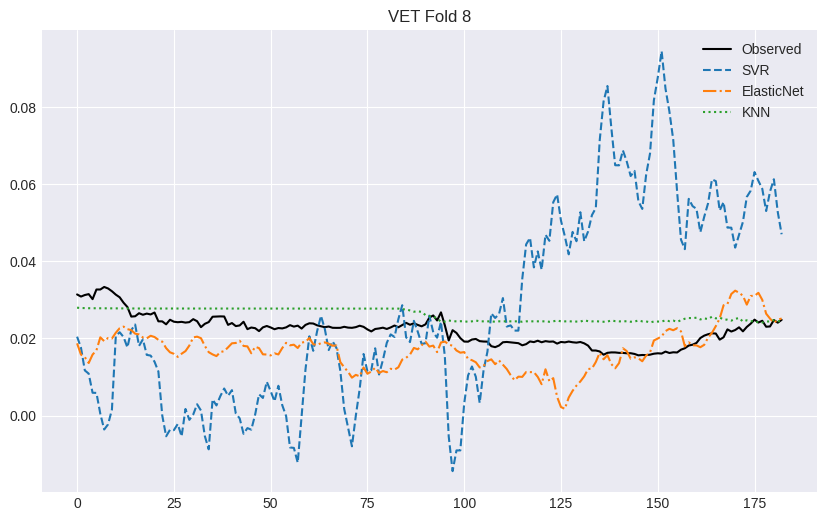

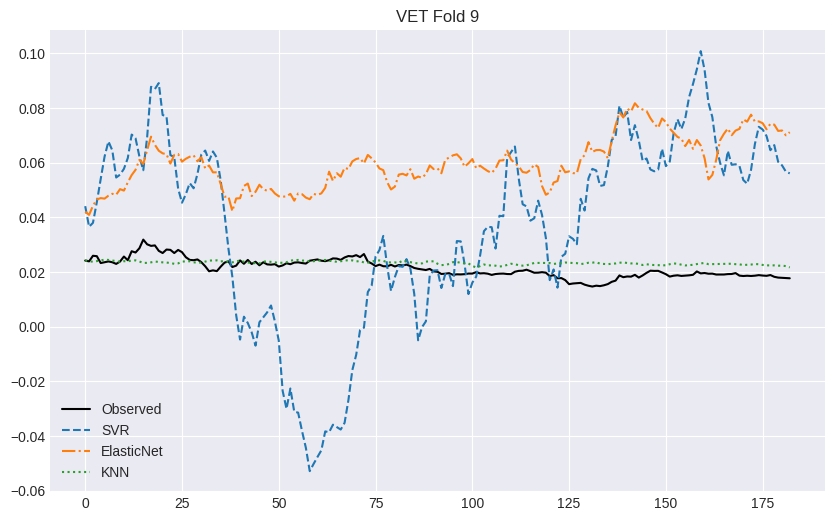

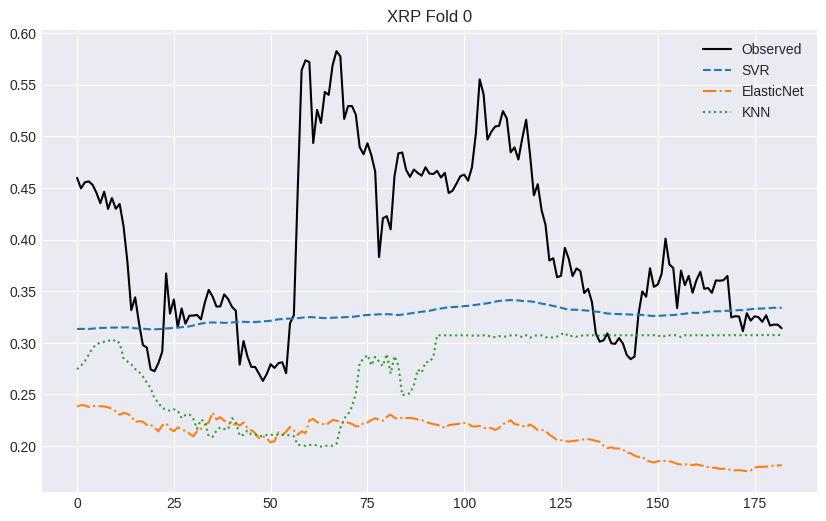

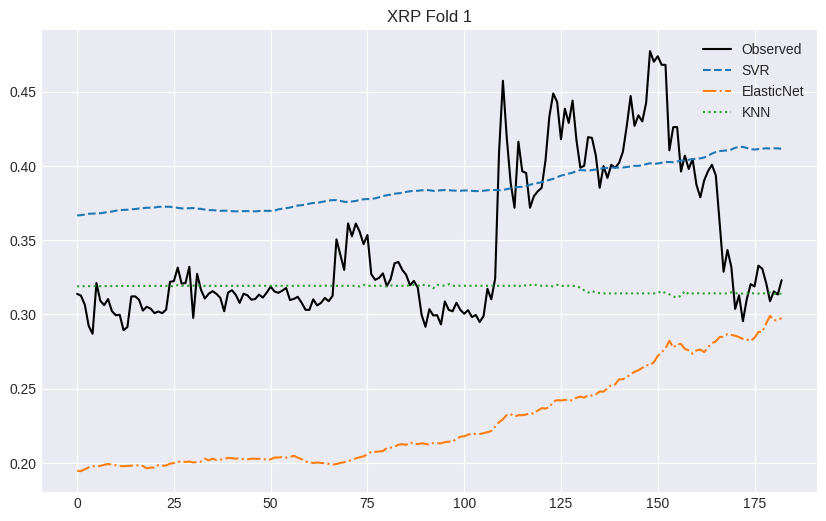

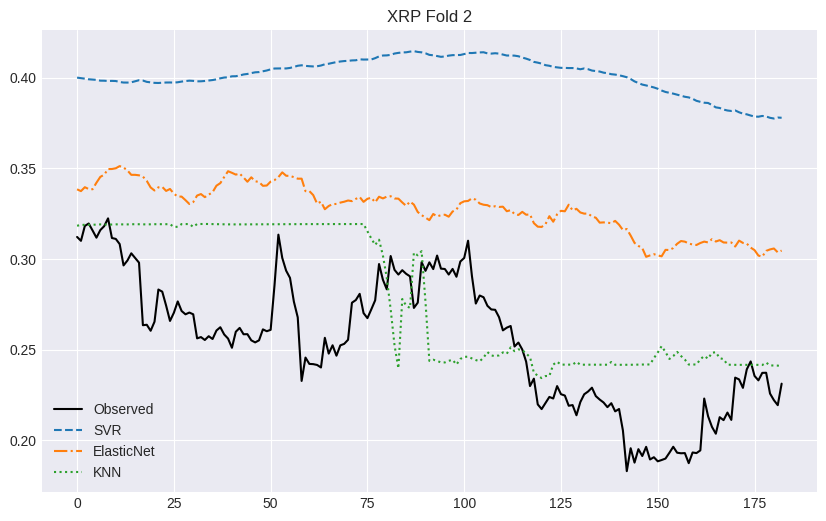

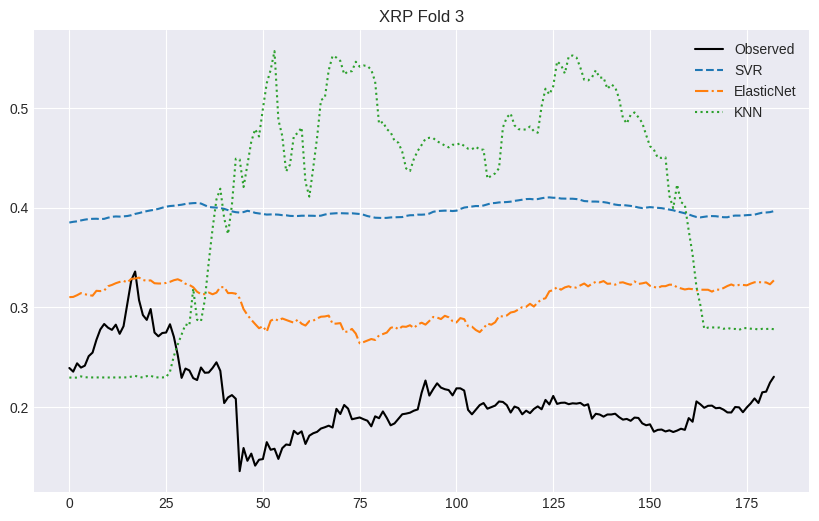

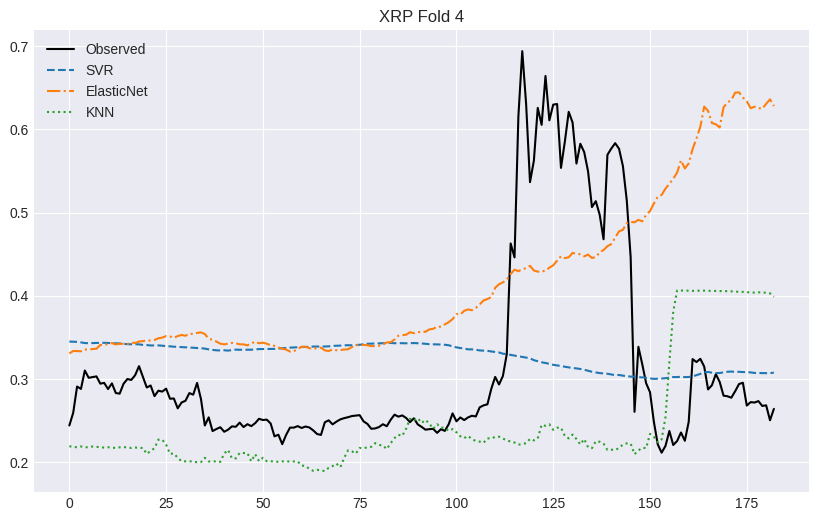

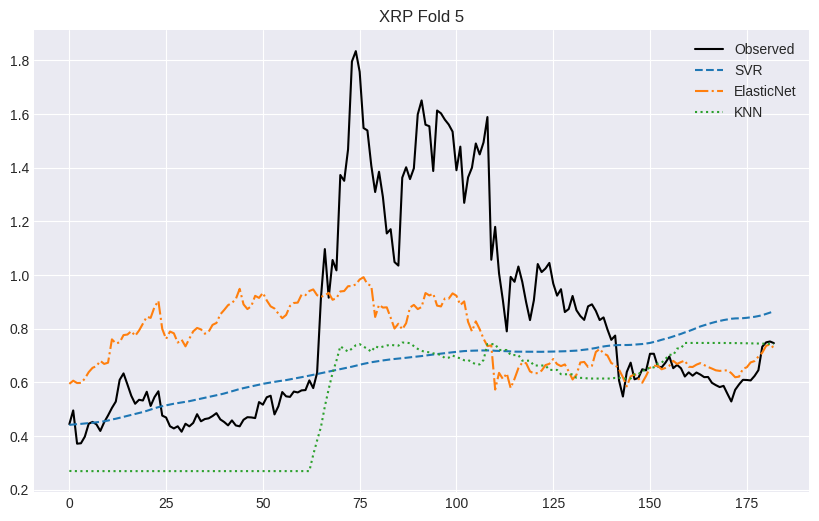

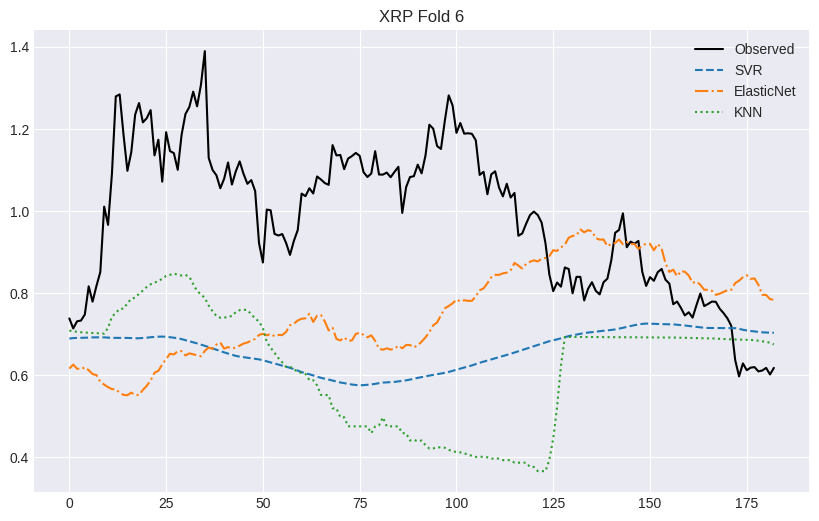

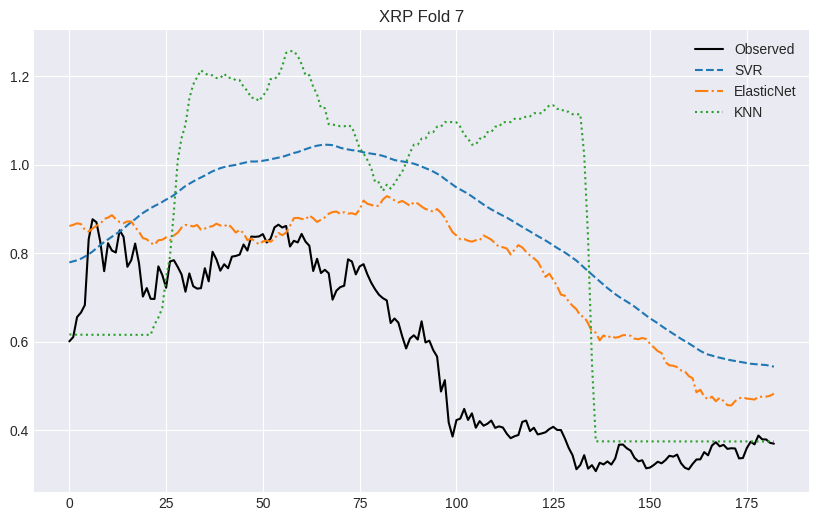

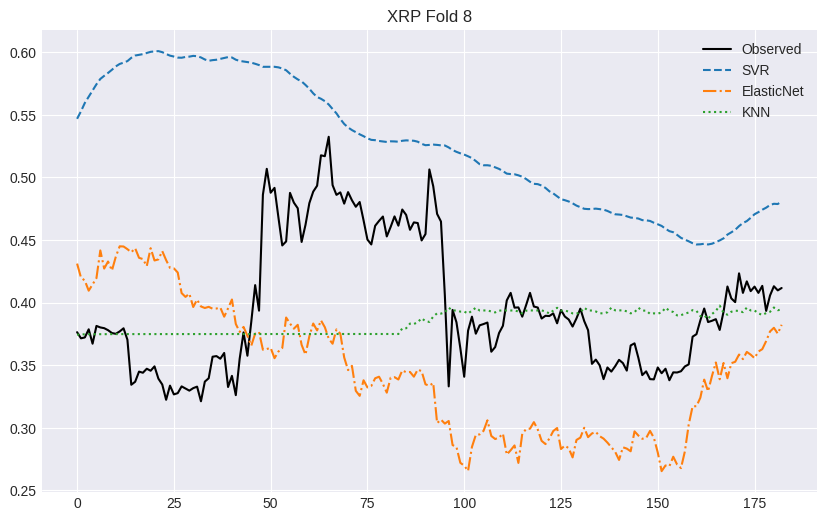

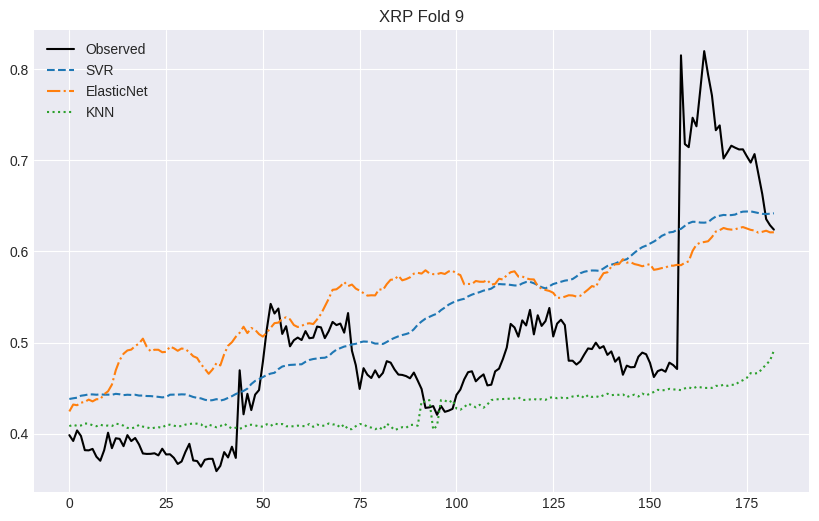

In [18]:
# Initialize a DataFrame to store metrics
metrics_df = pd.DataFrame(
    columns=["Crypto", "Fold", "Model"]
    + list(results_dict_svr["ETH_fold_1"]["metrics"].keys())
)
l = []
# Iterate through cryptocurrencies and folds
for crypto in SYMBOLS:
    for fold in range(10):
        fold_key = f"{crypto}_fold_{fold}"

        # Plot observed and predicted data
        plt.figure(figsize=(10, 6))

        # SVR
        svr_data = results_dict_svr.get(fold_key, {})
        plt.plot(svr_data.get("observed", []), label="Observed", color="black")
        plt.plot(svr_data.get("pred", []), label="SVR", linestyle="--")

        # ElasticNet
        elasticnet_data = results_dict_en.get(fold_key, {})
        plt.plot(elasticnet_data.get("pred", []), label="ElasticNet", linestyle="-.")

        # KNN
        knn_data = results_dict_knn.get(fold_key, {})
        plt.plot(knn_data.get("pred", []), label="KNN", linestyle=":")

        plt.title(f"{crypto} Fold {fold}")
        plt.legend()
        plt.savefig(f"results/{crypto}_fold_{fold}")
        plt.show()

        # Store metrics
        for model, model_dict in zip(
            ["SVR", "ElasticNet", "KNN"],
            [results_dict_svr, results_dict_en, results_dict_knn],
        ):
            metrics = model_dict.get(fold_key, {}).get("metrics", {})
            for metric, value in metrics.items():
                l.append(
                    {**{"Crypto": crypto, "Fold": fold, "Model": model}, **metrics}
                )

In [19]:
df = pd.DataFrame(l)

In [20]:
df

Crypto  Fold Model  pearsons_r          R2     SMAPE       MBE       MAE  \
0       ADA     0   SVR    0.580986 -421.754045  1.641184 -0.645946  0.645946   
1       ADA     0   SVR    0.580986 -421.754045  1.641184 -0.645946  0.645946   
2       ADA     0   SVR    0.580986 -421.754045  1.641184 -0.645946  0.645946   
3       ADA     0   SVR    0.580986 -421.754045  1.641184 -0.645946  0.645946   
4       ADA     0   SVR    0.580986 -421.754045  1.641184 -0.645946  0.645946   
...     ...   ...   ...         ...         ...       ...       ...       ...   
1675    XRP     9   KNN    0.681786   -0.153461  0.155065  0.064195  0.078074   
1676    XRP     9   KNN    0.681786   -0.153461  0.155065  0.064195  0.078074   
1677    XRP     9   KNN    0.681786   -0.153461  0.155065  0.064195  0.078074   
1678    XRP     9   KNN    0.681786   -0.153461  0.155065  0.064195  0.078074   
1679    XRP     9   KNN    0.681786   -0.153461  0.155065  0.064195  0.078074   

           MSE      RMSE  
0     0.417907  0.646457  
1     0.417907  0.646457  
2     0.417907  0.646457  
3     0.417907  0.646457  
4     0.417907  0.646457  
...        ...       ...  
1675  0.012686  0.112633  
1676  0.012686  0.112633  
1677  0.012686  0.112633  
1678  0.012686  0.112633  
1679  0.012686  0.112633  

[1680 rows x 10 columns]

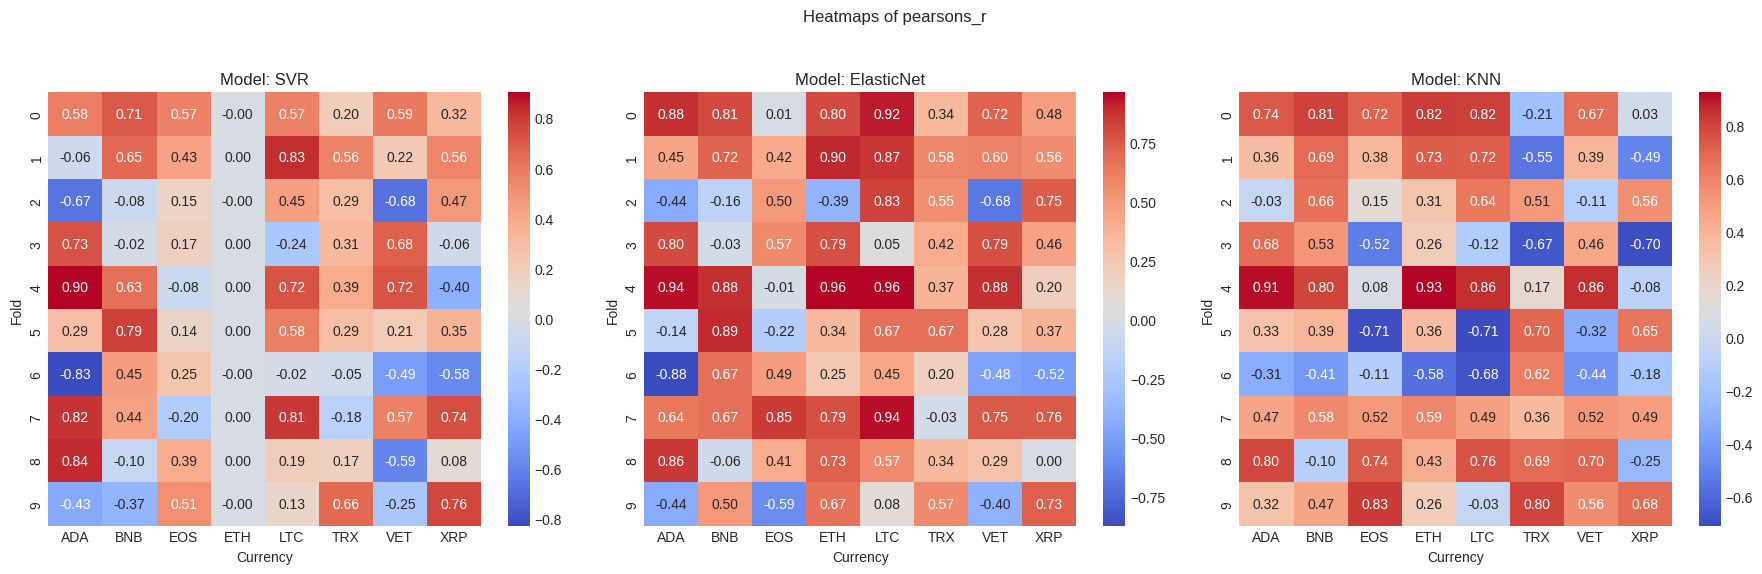

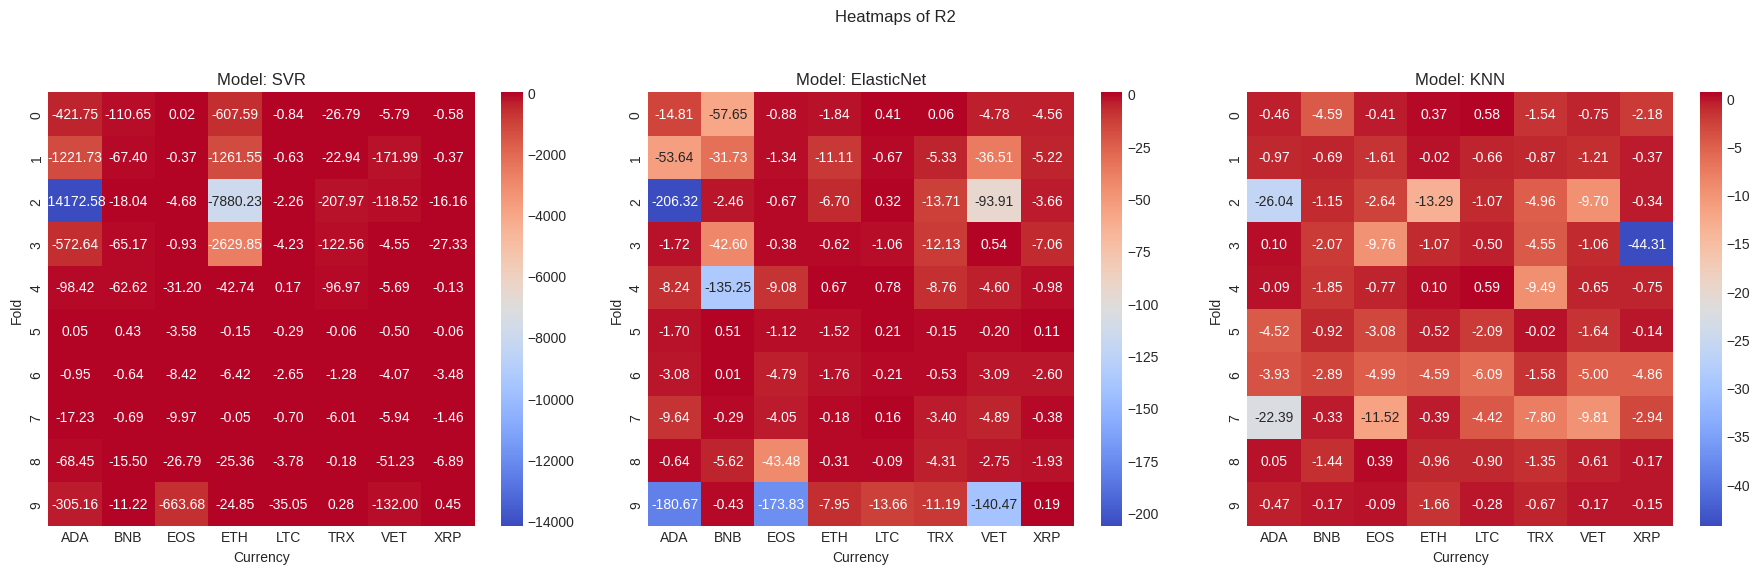

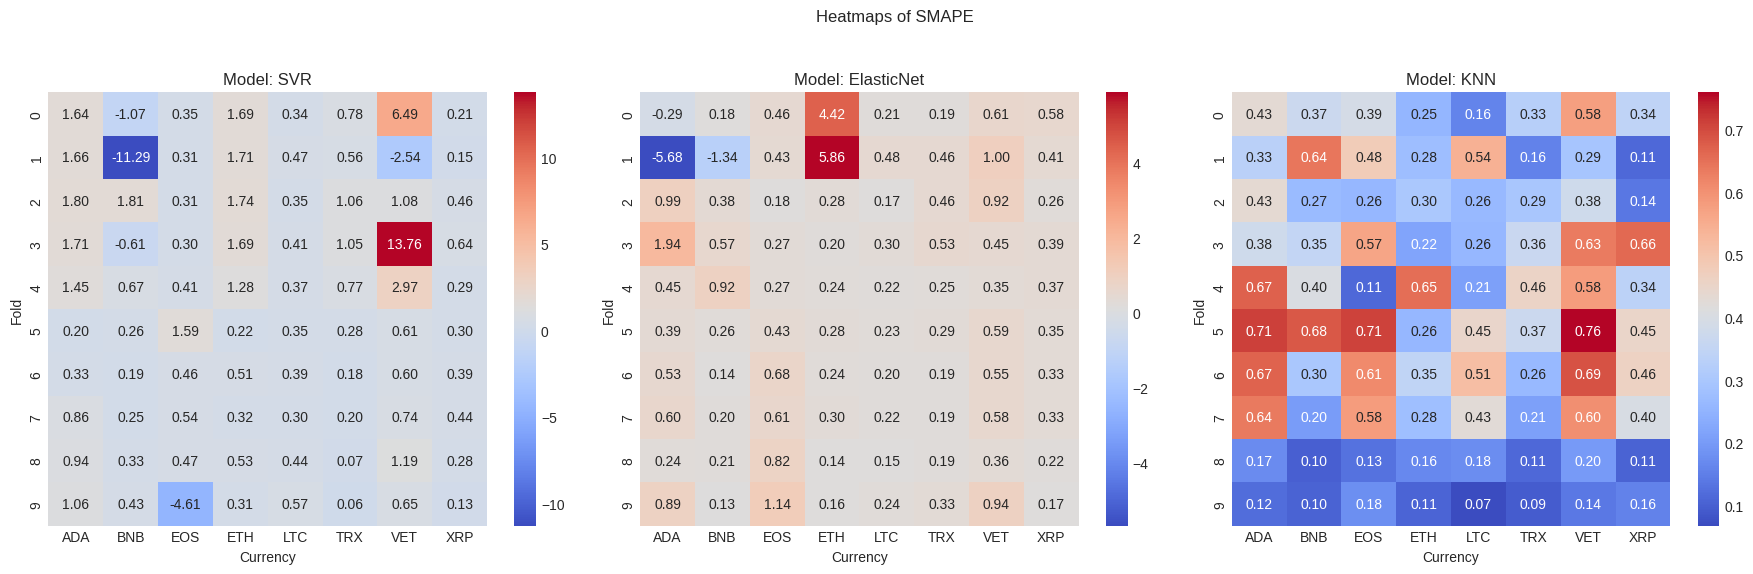

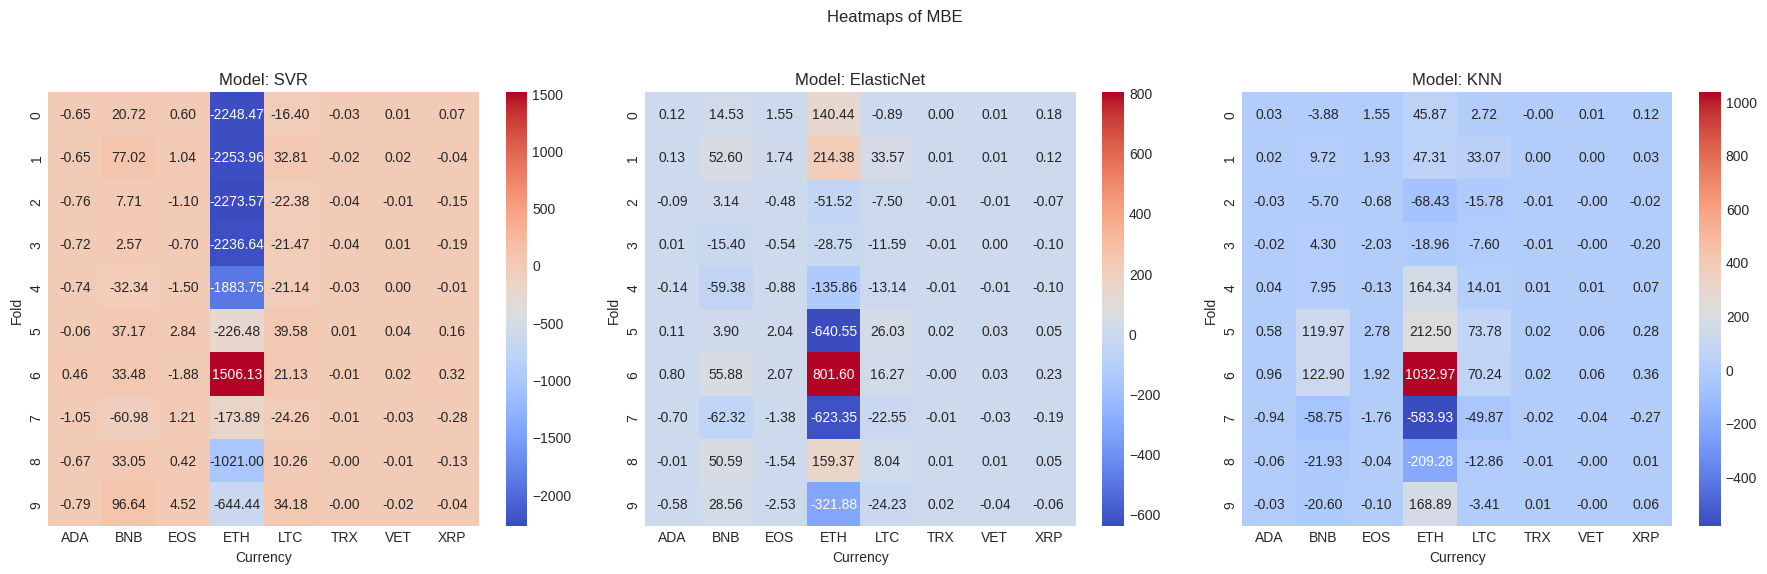

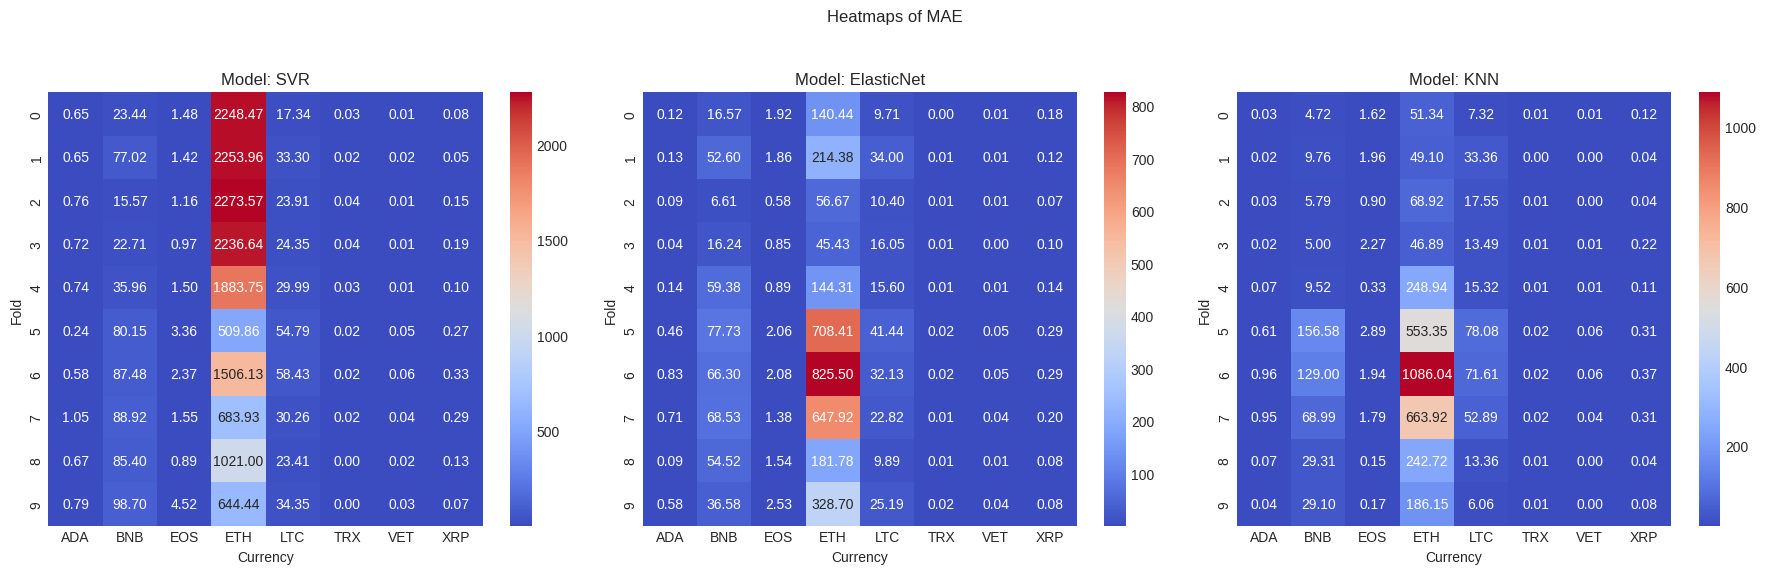

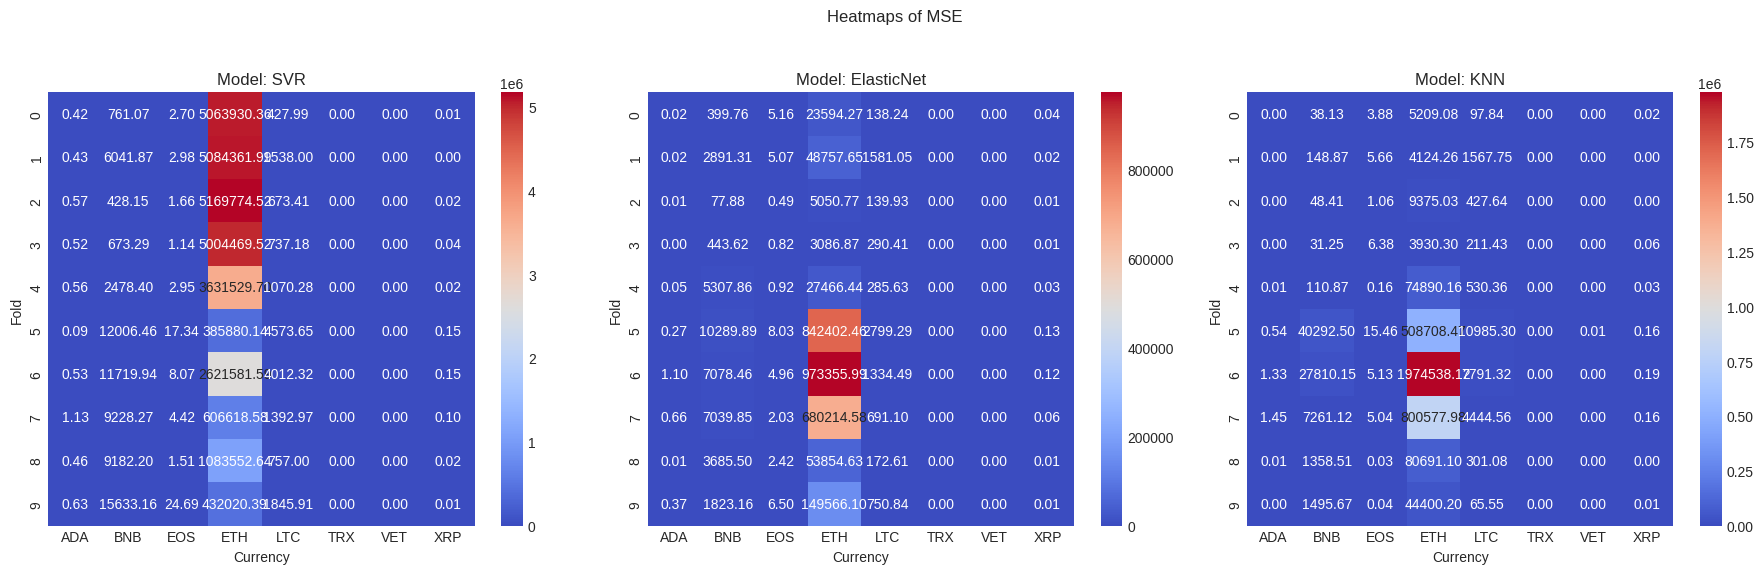

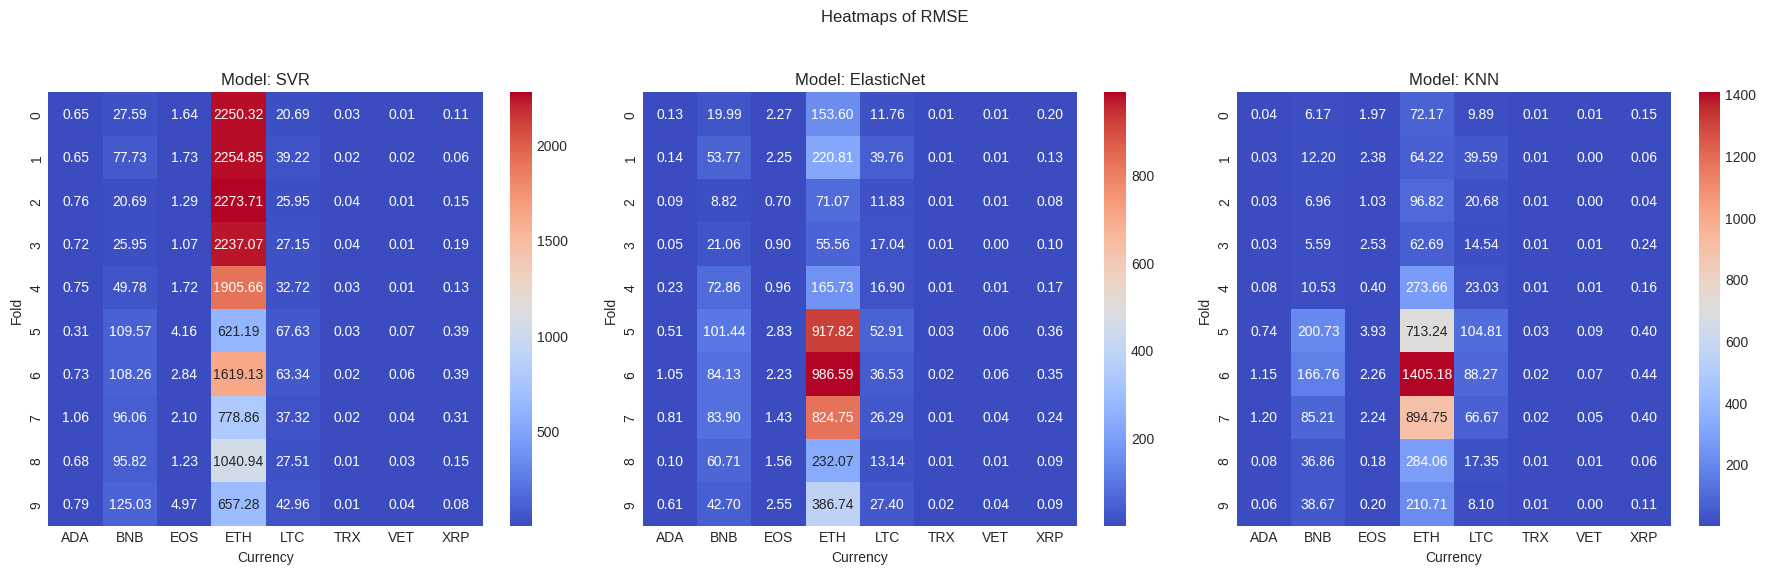

In [25]:
unique_metrics = [
    "pearsons_r",
    "R2",
    "SMAPE",
    "MBE",
    "MAE",
    "MSE",
    "RMSE",
]  # Add or remove metrics as needed
unique_models = df["Model"].unique()
unique_symbols = df["Crypto"].unique()

# Loop through each metric to create a single plot with three subplots
for metric in unique_metrics:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"Heatmaps of {metric}")

    for i, model in enumerate(unique_models):
        ax = axes[i]

        # Filter DataFrame for the current model
        df_filtered = df[df["Model"] == model]

        # Create a pivot table for the heatmap
        pivot_table = pd.pivot_table(
            df_filtered, values=metric, index=["Fold"], columns=["Crypto"]
        )
lying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.lying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
        sns.heatmap(pivot_table, annot=True, cmap="coolwarm", fmt=".2f", ax=ax)

        ax.set_title(f"Model: {model}")
        ax.set_xlabel("Currency")
        ax.set_ylabel("Fold")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # Save the figure before showing it
    plt.savefig(f"./results/Heatmaps_of_{metric}.png")
    plt.show()